<a href="https://colab.research.google.com/github/jaya-shankar/education-impact/blob/master/All_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloning Repo & installing libs

In [1]:
!rm -rf education-impact

In [2]:
!git clone https://github.com/jaya-shankar/education-impact.git


Cloning into 'education-impact'...
remote: Enumerating objects: 483, done.
remote: Counting objects: 100% (483/483), done.
remote: Compressing objects: 100% (406/406), done.
remote: Total 483 (delta 256), reused 215 (delta 74), pack-reused 0
Receiving objects: 100% (483/483), 8.21 MiB | 13.14 MiB/s, done.
Resolving deltas: 100% (256/256), done.


In [3]:
!pip install tensorflow_decision_forests
!pip install wurlitzer
!pip install seaborn

     |████████████████████████████████| 13.3 MB 4.9 MB/s 


In [198]:
import pandas as pd
import os
import numpy as np
import math
import seaborn as sns
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from wurlitzer import sys_pipes
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


# Setting paths

In [5]:
root = "education-impact/datasets/" 
datasets_path = {
                    "infant_mortality"                :  root+ "Infant_Mortality_Rate.csv",
                    "child_mortality"                 :  root+ "child_mortality_0_5_year_olds_dying_per_1000_born.csv",
                    "children_per_woman"              :  root+ "children_per_woman_total_fertility.csv",
                    "co2_emissions_percapita"         :  root+ "co2_emissions_tonnes_per_person.csv",
                    "population"                      :  root+ "converted_pop.csv",
                    "population_density"              :  root+ "population_per_area.csv",
                    "gdp_growth"                      :  root+ "gdp_per_capita_yearly_growth.csv",
                    "Avg_daily_income_ppp"            :  root+ "mincpcap_cppp.csv",
                    "gdppercapita_us_infla_adjust"    :  root+ "gdppercapita_us_inflation_adjusted.csv",
                    "gini_index"                      :  root+ "gini.csv",
                    "life_expectancy"                 :  root+ "life_expectancy_years.csv",
                    "poverty_index"                   :  root+ "mincpcap_cppp.csv",
                    "people_in_poverty"               :  root+ "number_of_people_in_poverty.csv",
                    "ratio_b/g_in_primary"            :  root+ "ratio_of_girls_to_boys_in_primary_and_secondary_education_perc.csv",
                    "wcde-25--34"                     :  root+ "wcde-25--34.csv",
                    "20-24-In_Primary_OL"             :  root+ "In_Primary_OL.csv",
                    "20-24-Primary_OL"                :  root+ "Primary_OL.csv",
                    "20-24-Lower_Secondary_OL"        :  root+ "Lower_Secondary_OL.csv",
                    "20-24_female-In_Primary_OL"      :  root+ "female_In_Primary_OL.csv",
                    "20-24_female-Primary_OL"         :  root+ "female_Primary_OL.csv",
                    "20-24_female-Lower_Secondary_OL" :  root+ "female_Lower_Secondary_OL.csv",
                    "20-24-In_Primary_OL_comp"        :  root+ "In_Primary_OL_complete.csv",
                    "20-24-Primary_OL_comp"           :  root+ "Primary_OL_complete.csv",
                    "20-24-Lower_Secondary_OL_comp"   :  root+ "Lower_Secondary_OL_complete.csv",
                }

created_datasets = []

# Defining common functions

In [514]:
def get_countries_count(datasets):
  for dataset in datasets:
    df = pd.read_csv(datasets_path[dataset])
    count = len(set(df.Country.unique()))
    print(f"{'Factor: ' + dataset:<40} count: {count}")


In [515]:
def find_common_countries(datasets,o_dataset=None):
  common_countries = set()
  first_time = True
  for dataset in datasets:
    countries_list = list(pd.read_csv(datasets_path[dataset]).Country)
    countries_list = set(map(lambda x: x.lower(), countries_list))
    if first_time:
      common_countries = countries_list
      first_time = False
    else:
      common_countries = common_countries.intersection(countries_list)
  if o_dataset !=None:
    countries_list = list(pd.read_csv(datasets_path[o_dataset]).Country)
    countries_list = set(map(lambda x: x.lower(), countries_list))
    common_countries = common_countries.intersection(countries_list)
  return list(common_countries)

In [516]:
def generate_indices(countries,years):
  keys=[]
  for y in years:
    for c in countries:
      keys.append((c,str(y)))
  return keys

In [517]:
def load_datasets_to_pd(datasets,keys,include_output=True,o_dataset=None):
  combined_df = pd.DataFrame(keys,columns=['country','year'])
  for dataset in datasets:
    print("loading " + dataset)
    combined_df = add_dataset(combined_df,dataset)
    

  if o_dataset!=None:
    combined_df = add_dataset(combined_df,o_dataset,output = True)
  return combined_df

  

In [518]:
def add_dataset(input_df,dataset,output = False):
  label = dataset
  if output : 
    label = "o_"+OUTPUT
  input_df[label] = [math.nan]*len(input_df)
  df = pd.read_csv(datasets_path[dataset])
  df["Country"] = df["Country"].str.lower()
  df.set_index("Country", inplace=True)
  for e in range(len(input_df)):
    country = input_df.iloc[e].country
    year    = input_df.iloc[e].year
  
    if output:
      input_df.at[e,label] = df.loc[country][str( int(year) + PREDICT_FUTURE )]
    else:
      input_df.at[e,label] = df.loc[country][year]
    
  return input_df

In [519]:
def create_n_yrs_old_csv(dataset,n):
    table_name = str(n)+"_yrs_old_"+dataset
    # if table_name in created_datasets:
    #   return table_name
    df = pd.read_csv(datasets_path[dataset])
    years = list(range(1960, 2016))
    countries = list(df['Country'])
    new_df = pd.DataFrame(countries,columns=['Country'])
    for i in range(1960,2016):
      new_df[i] = np.nan
    new_df.set_index('Country',inplace=True)
    df.set_index('Country',inplace=True)
    for c in countries:
      for y in range(1960+n,2016):
        new_df[y].at[c] = df.loc[c][str(y-n)]
    
    
    datasets_path[table_name] = root+table_name+".csv"
    new_df.to_csv(root+table_name+".csv",encoding='utf-8', index=True)

    created_datasets.append(table_name)
    return table_name

In [520]:
def create_n_dropout_csv(dataset,n,s_n = 90):
    df = pd.read_csv(datasets_path[dataset])
    years = list(range(1875, 2016))
    countries = list(df['Country'])
    drop_out_years = []
    for i in range(len(df)):
      started = False
      s_year  = 1875
      for year in years:
        if not started and df.iloc[i][str(year)] < s_n :
          started = True
          s_year  = year
        elif started and df.iloc[i][str(year)] < n :
          drop_out_years.append((df.iloc[i]['Country'],(year-s_year)))
          break
      else:
        if started:
          drop_out_years.append((df.iloc[i]['Country'], 100))
        else:
          drop_out_years.append((df.iloc[i]['Country'], year-s_year))
    new_df = pd.DataFrame(countries,columns=['Country'])
    for i in years:
      new_df[i] = np.nan
    new_df.set_index('Country',inplace=True)
    for c,y in drop_out_years:
      for i in years:
        new_df.at[c,i] = y
    table_name = str(n)+"%_dropout_"+dataset
    datasets_path[table_name] = root+table_name+".csv"
    new_df = new_df[(new_df.T != 1).any()]
    new_df.to_csv(root+table_name+".csv",encoding='utf-8', index=True)

    created_datasets.append(table_name)
    return table_name

In [521]:
def combine_dfs(X,y):
  label = y.columns[0]
  X[label] = y
  X.dropna(subset=[label],inplace=True)
  return X

In [522]:
def extract_variable_imp(variable):
  v_list = inspector.variable_importances()[variable]
  v = variable + "\n"

  for i in range(0,len(v_list)):
    if v_list[0][0]!='_':
      v += str(i)+ "  "
      v += f"{v_list[i][0][0]:<50}" 
      v += str(v_list[i][1]) + "\n"
  return v

In [523]:
def rate_of_dropout(dataset,n):
  table_name = str(n)+"_yr_period_rate_of_change_of_"+dataset

  years  = [y for y in range(1960,2016)]
  edu_df = pd.read_csv(datasets_path[dataset])
  countries = list(edu_df['Country'])
  new_df = pd.DataFrame(countries,columns=['Country'])
  for i in years:
    new_df[i] = np.nan
  new_df.set_index('Country',inplace=True)
  edu_df.set_index('Country',inplace=True)
  for c in countries:
    for y in range(1960+n,2016):
      new_df[y].at[c] = (edu_df.loc[c][str(y-n)] - edu_df.loc[c][str(y)])/n

  datasets_path[table_name] = root+table_name+".csv"
  
  new_df.to_csv(root+table_name+".csv",encoding='utf-8', index=True)

  created_datasets.append(table_name)
  return table_name




In [524]:
def finish_edu(dataset):
  df = pd.read_csv(datasets_path[dataset])
  names = {
            "20-24-In_Primary_OL" : "20-24-Primary_fin",
            "20-24-Primary_OL"     : "20-24-Lower_Secondary_fin",
           "20-24-Lower_Secondary_OL" : "20-24-Higher_Secondary_fin",
           "20-24_female-In_Primary_OL" : "20-24-female_Primary_fin",
            "20-24_female-Primary_OL"     : "20-24-female_Lower_Secondary_fin",
           "20-24_female-Lower_Secondary_OL" : "20-24-female_Higher_Secondary_fin"
      
          }
  # read csv 
    # atleast primary = 100 - in_primary_ol
    # atleast lower secondary = 100 - primary_ol
    # atleast higer secondary = 100 - lowersecondary_ol
  # if female:
  #   df.drop(df.columns[0], axis=1)
  df.set_index(["Country"], inplace=True)
  df.apply(pd.to_numeric)
  df = df.sub(100)
  df = df.mul(-1)
  table_name = names[dataset]
  print(table_name)
  df.to_csv(root+table_name+".csv",encoding='utf-8', index=True)
  datasets_path[table_name] = root+table_name+".csv"
  return table_name
  

In [525]:
edu_list = ["20-24-In_Primary_OL",
            "20-24-Primary_OL",
            "20-24-Lower_Secondary_OL",
             "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL" ,
            "20-24_female-Lower_Secondary_OL",
            ]

for i in edu_list:
  finish_edu(i)

20-24-Primary_fin
20-24-Lower_Secondary_fin
20-24-Higher_Secondary_fin
20-24-female_Primary_fin
20-24-female_Lower_Secondary_fin
20-24-female_Higher_Secondary_fin


In [606]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel(f'Error {OUTPUT}')
  plt.legend()
  plt.grid(True)

In [527]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [605]:
def plot_test_data(test_predicted,test_output_np):
    plt.plot(test_predicted, label='predicted')
    plt.plot(test_output_np, label='actual')
    # plt.ylim([0, ])
    plt.xlabel('years')
    plt.ylabel(OUTPUT)
    # default_x_ticks = range(56)
    # plt.xticks(default_x_ticks, range(1960,2016))
    plt.locator_params(axis="x", nbins=10)
    plt.legend()


# Plotting Data

In [18]:
datasets_to_plot = [
            "life_expectancy",
            "infant_mortality",
            "child_mortality",

            "children_per_woman",

            "20-24-Primary_fin",
            "20-24-Lower_Secondary_fin",
            "20-24-Higher_Secondary_fin",

            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            "gdp_growth",
            
            "population",
            

            ]

# creating a list of all countries & years
countries   = find_common_countries(datasets_to_plot)
# years       = [y for y in range(1960,2016)]
years       = [2010]
keys        = generate_indices(countries, years)

combined_df_comp = load_datasets_to_pd(datasets_to_plot,keys,include_output=False)

loading life_expectancy
loading infant_mortality
loading child_mortality
loading children_per_woman
loading 20-24-Primary_fin
loading 20-24-Lower_Secondary_fin
loading 20-24-Higher_Secondary_fin
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading gdp_growth
loading population


In [ ]:
combined_df_comp.describe()

,life_expectancy,infant_mortality,child_mortality,children_per_woman,20-24-Primary_fin,20-24-Lower_Secondary_fin,20-24-Higher_Secondary_fin,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,gdp_growth,population
count,9856.000000,8955.000000,9856.000000,9856.000000,9856.000000,9856.000000,9856.000000,9676.000000,9856.000000,7685.000000,9848.000000,9.856000e+03
mean,64.719734,54.513255,87.541769,4.161540,71.389712,57.170272,35.871966,4.448684,39.678155,9056.120494,2.061148,2.860715e+07
std,10.086496,47.024194,83.890440,2.046004,30.973840,34.189538,31.199226,7.331387,9.833643,14068.705259,6.698984,1.104936e+08
min,9.500000,1.800000,2.180000,1.120000,0.100000,-0.000000,-0.100000,0.000000,16.000000,124.000000,-67.500000,4.120000e+04
25%,57.100000,15.600000,20.400000,2.210000,46.090000,25.100000,6.700000,0.364500,32.500000,1170.000000,-0.169000,1.690000e+06
50%,66.900000,41.000000,57.500000,3.900000,84.610000,57.810000,27.800000,1.640000,39.900000,3170.000000,2.140000,5.490000e+06
75%,72.400000,83.850000,134.000000,6.110000,98.980000,94.005000,61.655000,6.270000,45.100000,9450.000000,4.460000,1.660000e+07
max,84.300000,279.700000,423.000000,8.870000,100.000000,100.000000,100.000000,101.000000,77.000000,112000.000000,145.000000,1.410000e+09


In [ ]:
combined_df = combined_df_comp[(combined_df_comp.gdppercapita_us_infla_adjust<10000) & (combined_df_comp.gdp_growth>-15) &(combined_df_comp.co2_emissions_percapita<5.0)&(combined_df_comp.population<1.660000e+07)& (combined_df_comp.gdp_growth<15)  ]
combined_df = combined_df.sample(frac = 0.99, random_state=43)
combined_df.shape

(67, 14)

## Life Expectancy

ValueError: ignored

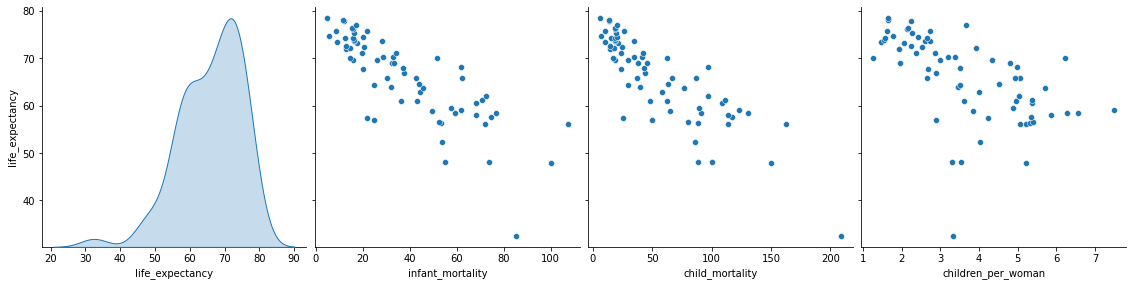

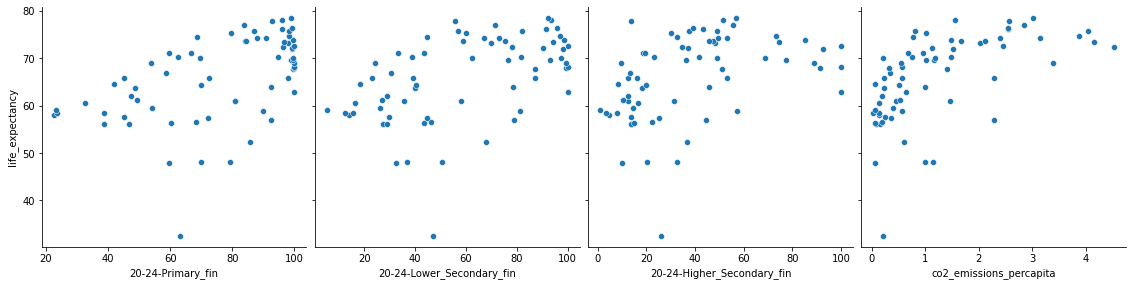

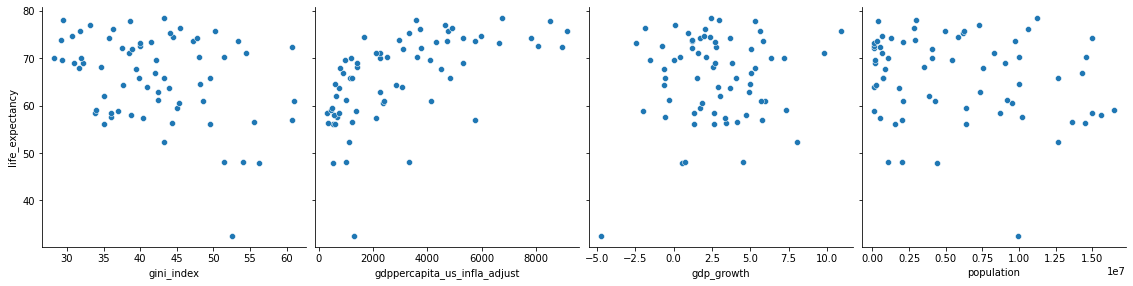

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = 'life_expectancy'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
# combined_df.sort_values(by=['life_expectancy'],inplace=True)
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


[32.5 47.8 48.  48.1 52.3 56.  56.2 56.3 56.5 57.  57.4 57.6 57.9 58.4
 58.5 58.8 59.  59.5 60.6 61.1 61.9 62.8 63.7 64.  64.4 64.5 65.7 65.8
 65.9 66.9 67.6 68.  68.1 71.  71.1 71.9 72.2 72.3 72.5 73.1 73.4 73.5
 73.6 73.9 74.2 74.3 74.4 74.7 75.2 75.6 75.7 76.2 76.3 76.9 77.8 78.1
 78.5]


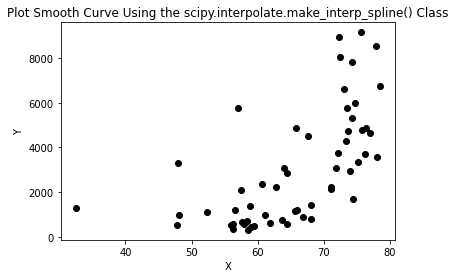

In [ ]:
# from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
plot_df = combined_df[['gdppercapita_us_infla_adjust',"life_expectancy"]]
# regr = linear_model.LinearRegression()
# regr.fit(c, y)
# Plot outputs
plot_df.sort_values(by=['life_expectancy'],inplace=True)
plot_df = plot_df[(plot_df['life_expectancy']!=69.0)]
plot_df = plot_df[(plot_df['life_expectancy']!=70.0)]
plot_df = plot_df[(plot_df['life_expectancy']!=69.6)]
plot_df = plot_df[(plot_df['life_expectancy']!=60.9)]
plot_df = plot_df[(plot_df['life_expectancy']!=70.3)]
# print(plot_df)
x,y = plot_df['life_expectancy'],plot_df['gdppercapita_us_infla_adjust']
x = x.to_numpy()
y = y.to_numpy()
print(x)
# prev=0
# for i in x:
#   if prev>=i:
#     print(i)
#   prev=i 
# print(x)
# print(x.ndim!=1)
# print(np.any(x[1:] <= x[:-1]))
X_Y_Spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
plt.scatter(x, y, color="black")
# plt.plot(X_, Y_)
plt.title("Plot Smooth Curve Using the scipy.interpolate.make_interp_spline() Class")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Total Fertility Rate

ValueError: ignored

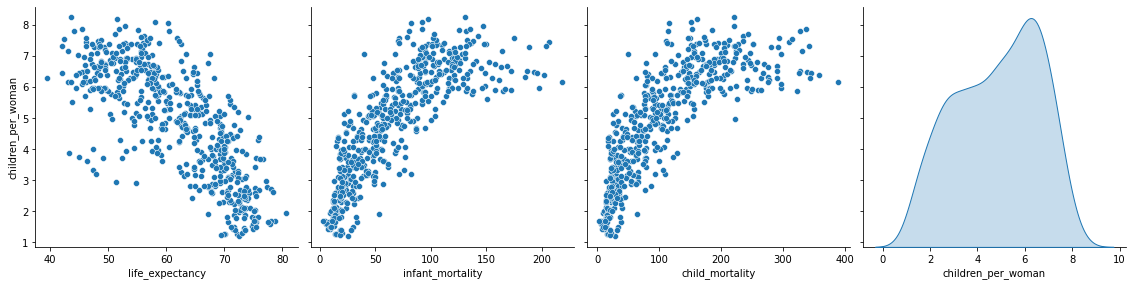

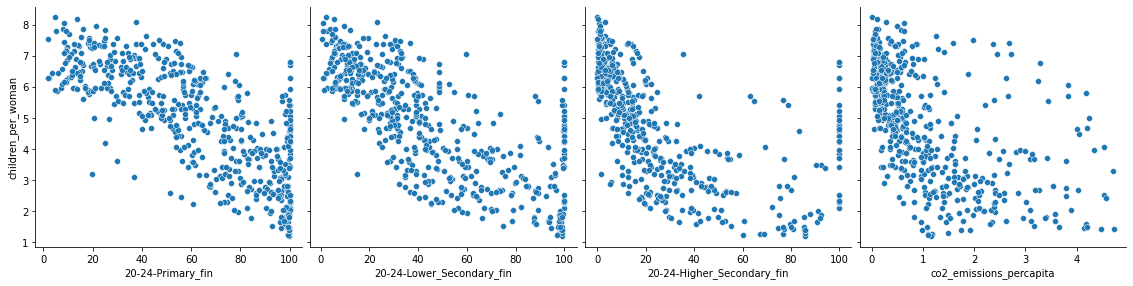

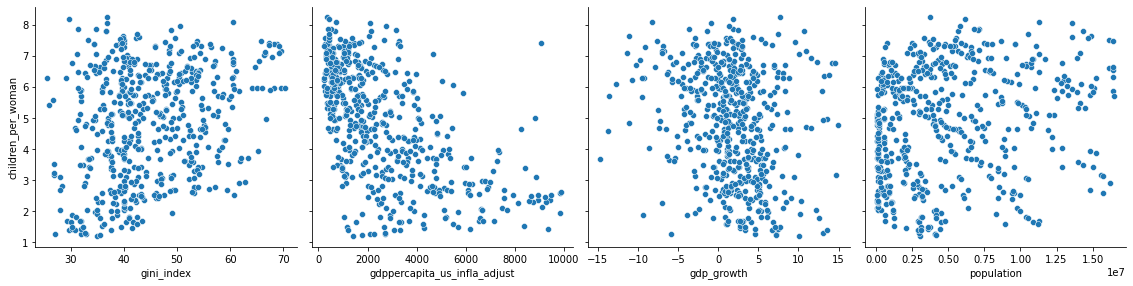

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = 'children_per_woman'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

## Primary education OL

ValueError: ignored

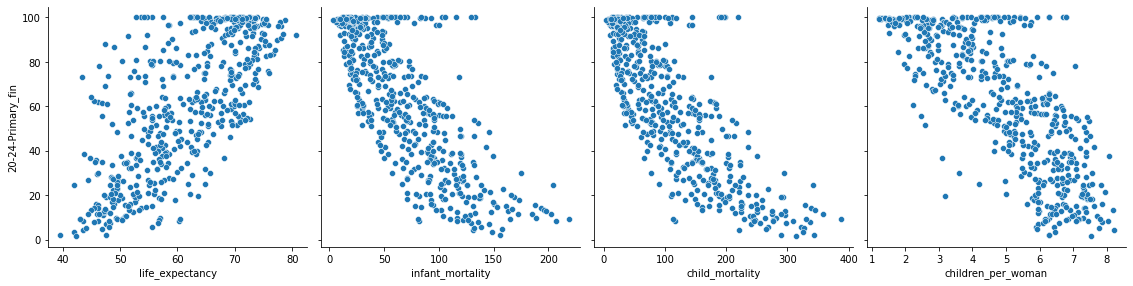

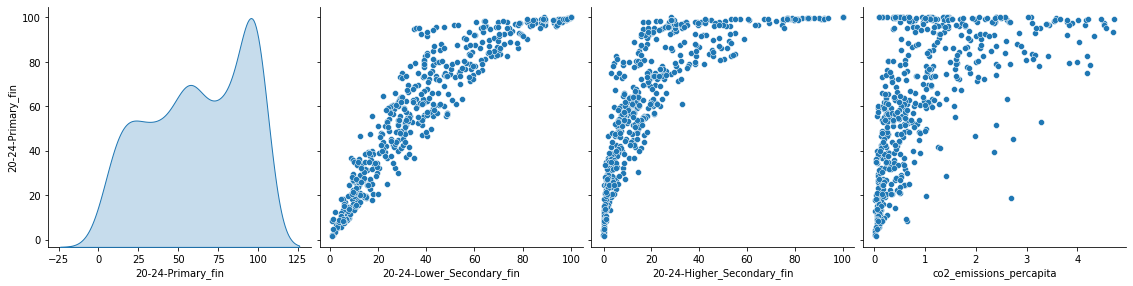

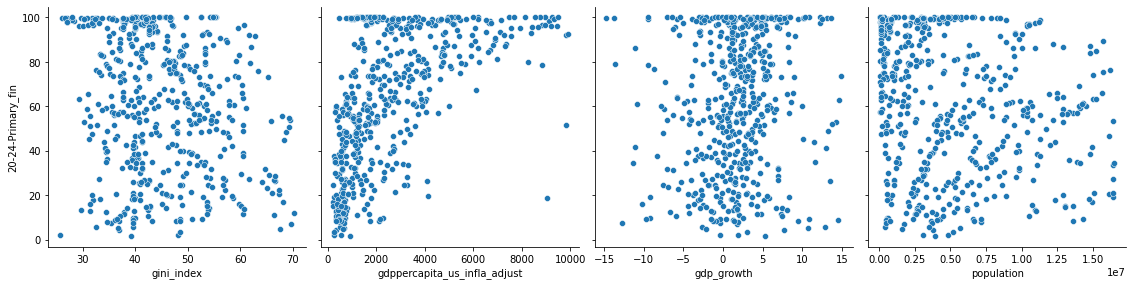

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = '20-24-Primary_fin'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

## Lower Secondary Education education OL

ValueError: ignored

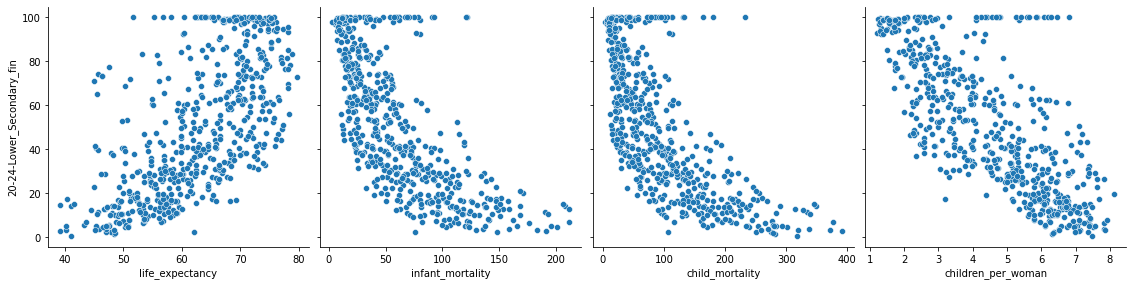

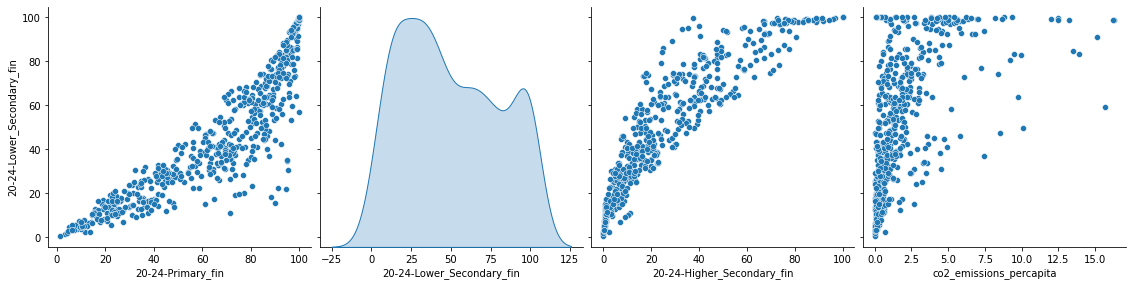

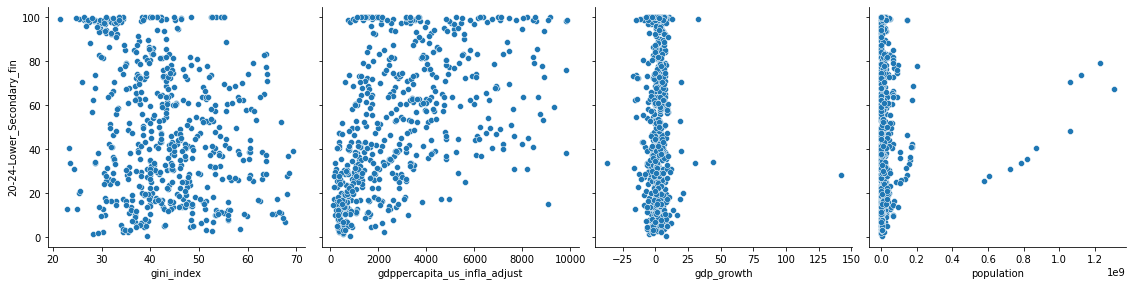

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = '20-24-Lower_Secondary_fin'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

## GDP per capita

ValueError: ignored

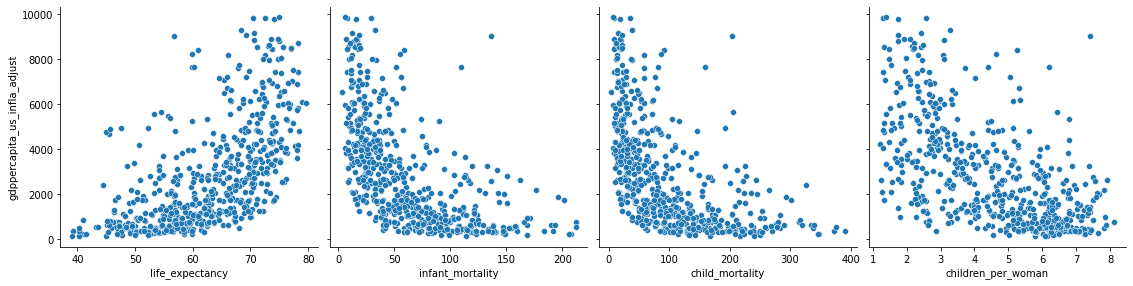

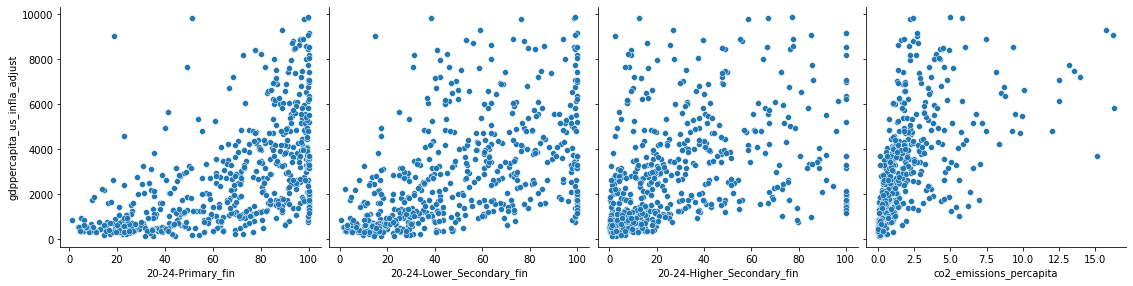

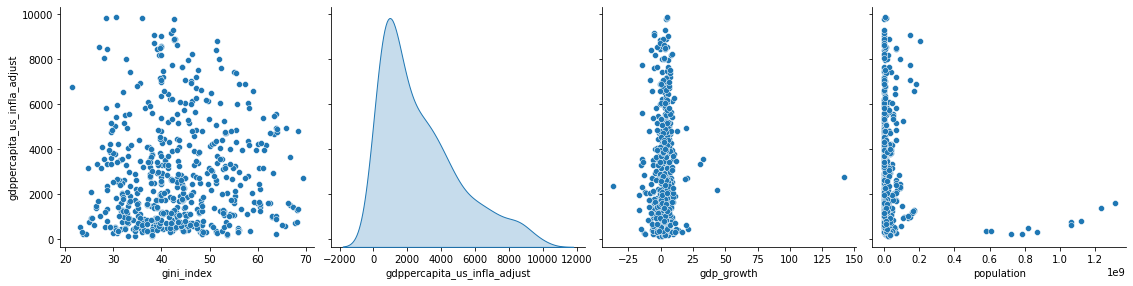

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = 'gdppercapita_us_infla_adjust'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

## 3D PLOT

### LE vs Edu vs GDP

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
combined_df_na = combined_df.dropna(subset=['gdppercapita_us_infla_adjust'])
x = combined_df_na['life_expectancy'].to_numpy()
y = combined_df_na['20-24-Primary_fin'].to_numpy()
z = combined_df_na['gdppercapita_us_infla_adjust'].to_numpy()

In [ ]:
plt.rcParams['figure.figsize'] = (8,6)

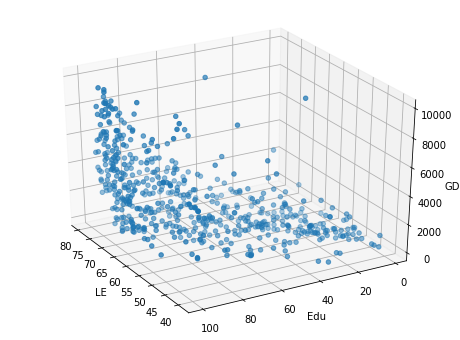

In [ ]:
ax = plt.axes(projection="3d")
ax.scatter3D(x,y,z)

ax.set_xlabel('LE')
ax.set_ylabel('Edu')
ax.set_zlabel('GDP')

ax.view_init(30,150)

# Selecting Countries

In [533]:
datasets_sc = [
            
            "life_expectancy",
            "20-24-Primary_fin",
            "20-24-Lower_Secondary_fin",
            "children_per_woman",
            "co2_emissions_percapita",
            "gdppercapita_us_infla_adjust",
            
            
            ]

In [534]:
countries = find_common_countries(datasets_sc,o_dataset = OUTPUT)
years     = [y for y in range(1960,2016)]
keys      = generate_indices(countries, years)

In [535]:
input_df_sc           = load_datasets_to_pd(datasets = datasets_sc, keys = keys)

loading life_expectancy
loading 20-24-Primary_fin
loading 20-24-Lower_Secondary_fin
loading children_per_woman
loading co2_emissions_percapita
loading gdppercapita_us_infla_adjust


In [536]:
input_1960 = input_df_sc[input_df_sc.year=='1960']
input_1960.describe()

,life_expectancy,20-24-Primary_fin,20-24-Lower_Secondary_fin,children_per_woman,co2_emissions_percapita,gdppercapita_us_infla_adjust
count,180.000000,180.000000,180.000000,180.000000,169.000000,85.000000
mean,56.463889,52.284444,35.646111,5.502000,2.386905,4188.494118
std,10.860480,36.945043,33.757925,1.761091,4.419895,5757.043633
min,27.500000,0.100000,-0.000000,1.910000,0.007980,131.000000
25%,46.900000,16.975000,6.925000,3.855000,0.152000,768.000000
50%,56.950000,44.850000,23.100000,6.250000,0.677000,1670.000000
75%,65.350000,95.125000,63.000000,6.882500,3.040000,3740.000000
max,73.500000,100.000000,100.000000,8.190000,36.600000,25500.000000


In [537]:
# bottom 50% countries in all aspects 
poor_gdp      = input_df_sc["gdppercapita_us_infla_adjust"]<1670
poor_co2      = input_df_sc["co2_emissions_percapita"]<0.677000
poor_edu      = input_df_sc["20-24-Primary_fin"]<44.8
poor_sec_edu  = input_df_sc["20-24-Lower_Secondary_fin"]<23.1
poor_tfr = input_df_sc.children_per_woman > 5
poor_lex = input_df_sc.life_expectancy <60
input_poor_countries = input_df_sc[poor_lex & poor_tfr & poor_sec_edu & poor_co2 & poor_edu & (input_df_sc['year']=='1960')]
input_poor_countries

,country,year,life_expectancy,20-24-Primary_fin,20-24-Lower_Secondary_fin,children_per_woman,co2_emissions_percapita,gdppercapita_us_infla_adjust
0,cape verde,1960,56.8,14.2,5.8,6.89,0.10900,NaN
5,niger,1960,40.3,1.1,0.4,7.45,0.00866,768.0
6,burkina faso,1960,39.5,2.3,1.3,6.29,0.00911,242.0
11,"congo, dem. rep.",1960,47.5,20.3,12.0,6.00,0.15200,1260.0
12,nepal,1960,44.6,9.5,5.3,5.96,0.00798,328.0
13,somalia,1960,45.0,5.4,5.0,7.25,0.03060,NaN
15,myanmar,1960,38.7,30.4,13.7,6.05,0.12500,131.0
17,sao tome and principe,1960,45.0,1.6,0.8,6.24,0.17100,NaN
19,solomon islands,1960,45.8,20.0,3.7,6.39,0.09340,NaN
20,liberia,1960,40.8,10.9,6.7,6.41,0.14800,NaN


In [538]:
poor_countries_list = list(input_poor_countries.country)
poor_countries_list.append('china')
poor_countries_list.append('south korea')
poor_countries_list.sort()
print(poor_countries_list)

poor_countries_set = set(poor_countries_list)

['afghanistan', 'algeria', 'angola', 'bangladesh', 'benin', 'brazil', 'burkina faso', 'burundi', 'cambodia', 'cameroon', 'cape verde', 'central african republic', 'chad', 'china', 'comoros', 'congo, dem. rep.', 'congo, rep.', "cote d'ivoire", 'ecuador', 'egypt', 'el salvador', 'equatorial guinea', 'eswatini', 'ethiopia', 'gambia', 'guatemala', 'guinea', 'guinea-bissau', 'haiti', 'honduras', 'india', 'indonesia', 'kenya', 'lao', 'liberia', 'madagascar', 'malawi', 'mali', 'mauritius', 'morocco', 'mozambique', 'myanmar', 'nepal', 'nicaragua', 'niger', 'nigeria', 'pakistan', 'rwanda', 'sao tome and principe', 'saudi arabia', 'senegal', 'sierra leone', 'solomon islands', 'somalia', 'south korea', 'south sudan', 'sudan', 'tanzania', 'togo', 'tunisia', 'uganda', 'vietnam']


# Building Model

## Life Expectancy

### Preparing the data

In [442]:
PREDICT_FUTURE  = 0
OUTPUT         = 'life_expectancy'
country_to_test = 'india'
test_results = {"predict" : OUTPUT}

In [443]:
datasets = [
            # "infant_mortality",
            # "life_expectancy",
            "child_mortality",
            # "children_per_woman",
            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            # create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            # create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            # "20-24-Lower_Secondary_OL",
            "population",
            # "20-24_female-Lower_Secondary_OL",
            "20-24-Primary_fin",
            "20-24-Higher_Secondary_fin",
            "20-24-Lower_Secondary_fin",
            "20-24-female_Primary_fin",
            "20-24-female_Lower_Secondary_fin",
            "20-24-female_Higher_Secondary_fin",
            ]
get_countries_count(datasets)

Factor: child_mortality                  count: 197
Factor: co2_emissions_percapita          count: 194
Factor: gini_index                       count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: population                       count: 197
Factor: 20-24-Primary_fin                count: 202
Factor: 20-24-Higher_Secondary_fin       count: 202
Factor: 20-24-Lower_Secondary_fin        count: 202
Factor: 20-24-female_Primary_fin         count: 202
Factor: 20-24-female_Lower_Secondary_fin count: 202
Factor: 20-24-female_Higher_Secondary_fin count: 202


In [ ]:
poor_countries_list

In [454]:
# creating a list of all countries & years
# countries = find_common_countries(datasets=datasets,o_dataset=OUTPUT)
countries = poor_countries_list
countries.remove(country_to_test)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [455]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
# input_df.set_index(["country","year"], inplace=True)
# output_df           = input_df[["o_" + OUTPUT]]
# input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading child_mortality
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading population
loading 20-24-Primary_fin
loading 20-24-Higher_Secondary_fin
loading 20-24-Lower_Secondary_fin
loading 20-24-female_Primary_fin
loading 20-24-female_Lower_Secondary_fin
loading 20-24-female_Higher_Secondary_fin


In [456]:
input_df

,country,year,child_mortality,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,population,20-24-Primary_fin,20-24-Higher_Secondary_fin,20-24-Lower_Secondary_fin,20-24-female_Primary_fin,20-24-female_Lower_Secondary_fin,20-24-female_Higher_Secondary_fin,o_life_expectancy
0,afghanistan,1960,357.0,0.0460,34.4,NaN,9000000.0,7.5,0.1,0.1,1.6,0.1,0.1,45.0
1,algeria,1960,243.0,0.5570,39.7,2170.0,11100000.0,18.3,0.3,10.1,8.1,4.1,0.1,52.4
2,angola,1960,308.0,0.1010,55.8,NaN,5450000.0,9.0,-0.0,2.1,3.2,1.3,0.1,46.3
3,bangladesh,1960,260.0,0.0461,24.9,463.0,48000000.0,22.5,1.1,11.4,10.6,2.9,0.1,43.8
4,benin,1960,311.0,0.0664,35.9,679.0,2430000.0,9.3,0.1,3.4,5.2,1.8,-0.0,44.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,tanzania,2015,59.1,0.2440,37.8,872.0,51500000.0,81.9,8.7,24.2,82.0,22.7,7.8,65.1
3412,togo,2015,76.8,0.3690,43.5,571.0,7320000.0,62.8,19.6,30.6,52.5,20.7,11.9,62.4
3413,tunisia,2015,17.2,2.6200,35.8,3860.0,11200000.0,97.8,52.2,90.3,97.2,89.1,55.3,77.0
3414,uganda,2015,54.8,0.1330,41.9,844.0,38200000.0,63.0,13.5,27.8,61.1,26.4,12.0,63.9


In [457]:
test_countries = [country_to_test]
# countries = poor_countries_list
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(test_countries, years)
test_input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
test_input_df.set_index(["country","year"], inplace=True)
test_output_df           = test_input_df[["o_" + OUTPUT]]
test_input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading child_mortality
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading population
loading 20-24-Primary_fin
loading 20-24-Higher_Secondary_fin
loading 20-24-Lower_Secondary_fin
loading 20-24-female_Primary_fin
loading 20-24-female_Lower_Secondary_fin
loading 20-24-female_Higher_Secondary_fin


In [ ]:
test_input_df

In [382]:
output_df

,,o_children_per_woman
country,year,
zambia,1960,7.12
uruguay,1960,2.88
paraguay,1960,6.50
niger,1960,7.45
burkina faso,1960,6.29
...,...,...
"micronesia, fed. sts.",2015,3.19
suriname,2015,2.40
guyana,2015,2.53


In [463]:
input_df.isna().sum()

child_mortality                      0
co2_emissions_percapita              0
gini_index                           0
gdppercapita_us_infla_adjust         0
population                           0
20-24-Primary_fin                    0
20-24-Higher_Secondary_fin           0
20-24-Lower_Secondary_fin            0
20-24-female_Primary_fin             0
20-24-female_Lower_Secondary_fin     0
20-24-female_Higher_Secondary_fin    0
dtype: int64

In [459]:
for i in range(1,input_df.shape[1]+1):
  print(f"{i} => {input_df.dropna(thresh=i).shape}")

1 => (3416, 14)
2 => (3416, 14)
3 => (3416, 14)
4 => (3416, 14)
5 => (3416, 14)
6 => (3416, 14)
7 => (3416, 14)
8 => (3416, 14)
9 => (3416, 14)
10 => (3416, 14)
11 => (3416, 14)
12 => (3416, 14)
13 => (3414, 14)
14 => (2821, 14)


In [ ]:
input_df.shape

### Finding optimal dataset

In [461]:
for i in range(12,input_df.shape[1]+1):
  input_df_cpy = input_df.dropna(thresh=i).copy()
  input_df_cpy.set_index(["country","year"], inplace=True)
  output_df_cpy           = input_df_cpy[["o_" + OUTPUT]]
  input_df_cpy.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)
  # converting pandas to tensorFlow dataset
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df_cpy,output_df_cpy), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
  model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
  model.fit(x=train_ds)
  model.compile(metrics=["mse"])
  print(f"For Threshold = {i} size is {input_df_cpy.shape}")
  print(model.make_inspector().evaluation())

Use /tmp/tmpx2z1qkx9 as temporary training directory
Starting reading the dataset
1/4 [======>.......................] - ETA: 1s
Dataset read in 0:00:00.413360
Training model
Model trained in 0:00:05.042850
Compiling model
4/4 [==============================] - 7s 2s/step
For Threshold = 12 size is (3416, 12)
Evaluation(num_examples=3416, accuracy=None, loss=None, rmse=1.9654810273330978, ndcg=None, aucs=None)
Use /tmp/tmpfqewsqvr as temporary training directory
Starting reading the dataset
1/4 [======>.......................] - ETA: 0s
Dataset read in 0:00:00.219118
Training model
Model trained in 0:00:03.186449
Compiling model
4/4 [==============================] - 4s 1s/step
For Threshold = 13 size is (3414, 12)
Evaluation(num_examples=3414, accuracy=None, loss=None, rmse=1.945477850153994, ndcg=None, aucs=None)
Use /tmp/tmptpfogjfl as temporary training directory
Starting reading the dataset
1/3 [=========>....................] - ETA: 0s
Dataset read in 0:00:00.220062
Training mode

In [462]:
input_df.dropna(thresh=14, inplace=True)
input_df.set_index(["country","year"], inplace=True)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

### Random Forest

In [472]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df.copy(),output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpukxieejl as temporary training directory
Starting reading the dataset


1/3 [=========>....................] - ETA: 0s
Dataset read in 0:00:00.281969
Training model
Model trained in 0:00:02.695093
Compiling model
3/3 [==============================] - 4s 2s/step


Evaluation(num_examples=2821, accuracy=None, loss=None, rmse=1.8877017540790835, ndcg=None, aucs=None)

In [473]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(test_input_df.copy(),test_output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

evaluation = model.evaluate(test_ds, return_dict=True)

test_results['random_forest'] = evaluation['mse']

1/1 [==============================] - 0s 152ms/step - loss: 0.0000e+00 - mse: 3.2313


In [474]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = model.predict(test_input_ds)

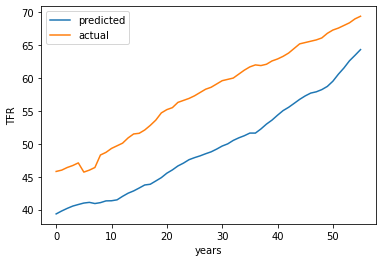

In [529]:
plot_test_data(test_predicted,test_output_np)

In [477]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=90)

In [478]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (11):
	20-24-Higher_Secondary_fin
	20-24-Lower_Secondary_fin
	20-24-Primary_fin
	20-24-female_Higher_Secondary_fin
	20-24-female_Lower_Secondary_fin
	20-24-female_Primary_fin
	child_mortality
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL" 10.496396 ################
    2.                 "20-24-Primary_fin"  8.378696 ############
    3.          "20-24-female_Primary_fin"  8.327062 ############
    4.         "20-24-Lower_Secondary_fin"  8.158121 ###########
    5.                        "gini_index"  8.0837

### Gradient Tree

In [481]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df.copy(),output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmp_11pg6z8 as temporary training directory
Starting reading the dataset


1/3 [=========>....................] - ETA: 0s
Dataset read in 0:00:00.314492
Training model
Model trained in 0:00:03.675070
Compiling model
3/3 [==============================] - 4s 2s/step


Evaluation(num_examples=None, accuracy=None, loss=1.4687694311141968, rmse=1.4687694311141968, ndcg=None, aucs=None)

In [482]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(test_input_df.copy(),test_output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

evaluation = model.evaluate(test_ds, return_dict=True)

test_results['gradient_tree'] = evaluation['mse']

1/1 [==============================] - 0s 218ms/step - loss: 0.0000e+00 - mse: 7.7516


In [483]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = model.predict(test_input_ds)

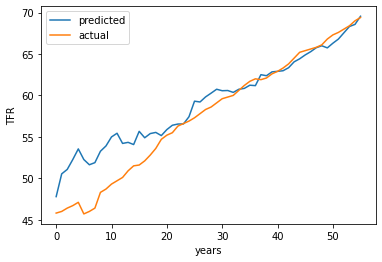

In [484]:
plot_test_tfr(test_predicted,test_output_np)

In [485]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [486]:
model.summary()

Model: "gradient_boosted_trees_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (11):
	20-24-Higher_Secondary_fin
	20-24-Lower_Secondary_fin
	20-24-Primary_fin
	20-24-female_Higher_Secondary_fin
	20-24-female_Lower_Secondary_fin
	20-24-female_Primary_fin
	child_mortality
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL"  4.648909 ################
    2. "20-24-female_Higher_Secondary_fin"  4.222565 ############
    3.  "20-24-female_Lower_Secondary_fin"  4.123512 ###########
    4.                 "20-24-Primary_fin"  4.025247 ##########
    5.          "20-24-female_Prima

### Linear Regression

In [ ]:
input_df.describe().transpose()[['mean', 'std']]

In [489]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [490]:
normalizer.adapt(np.array(input_df))

In [491]:
first = np.array(input_df[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[     243.          0.56       39.7      2170.   11100000.         18.3
         0.3        10.1         8.1         4.1         0.1 ]]

Normalized: [[ 1.23 -0.16 -0.38  0.05 -0.22 -1.08 -0.77 -0.87 -1.14 -0.89 -0.65]]


In [492]:
linear_model = tf.keras.Sequential([
    normalizer,
    keras.layers.Dense(units=1)
])

In [493]:
linear_model.predict(input_df[:10])

array([[-0.28864223],
       [-0.72087616],
       [-0.41718066],
       [ 0.04406633],
       [ 0.09468054],
       [-0.37892962],
       [-0.5799131 ],
       [ 0.6693092 ],
       [-0.78798616],
       [ 0.289366  ]], dtype=float32)

In [494]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mse')

In [495]:
input_df

,,child_mortality,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,population,20-24-Primary_fin,20-24-Higher_Secondary_fin,20-24-Lower_Secondary_fin,20-24-female_Primary_fin,20-24-female_Lower_Secondary_fin,20-24-female_Higher_Secondary_fin
country,year,,,,,,,,,,,
algeria,1960,243.0,0.55700,39.7,2170.0,11100000.0,18.3,0.3,10.1,8.1,4.1,0.1
bangladesh,1960,260.0,0.04610,24.9,463.0,48000000.0,22.5,1.1,11.4,10.6,2.9,0.1
benin,1960,311.0,0.06640,35.9,679.0,2430000.0,9.3,0.1,3.4,5.2,1.8,-0.0
brazil,1960,169.0,0.65000,44.3,2630.0,72200000.0,41.3,3.1,20.7,41.3,20.3,3.1
burkina faso,1960,343.0,0.00911,48.1,242.0,4830000.0,2.3,-0.0,1.3,0.9,0.4,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
tanzania,2015,59.1,0.24400,37.8,872.0,51500000.0,81.9,8.7,24.2,82.0,22.7,7.8
togo,2015,76.8,0.36900,43.5,571.0,7320000.0,62.8,19.6,30.6,52.5,20.7,11.9
tunisia,2015,17.2,2.62000,35.8,3860.0,11200000.0,97.8,52.2,90.3,97.2,89.1,55.3


In [496]:
%%time
history = linear_model.fit(
    input_df,
    output_df,
    epochs=20,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.43 s, sys: 187 ms, total: 3.61 s
Wall time: 3.07 s


In [497]:
linear_model.layers[1].kernel

<tf.Variable 'dense_24/kernel:0' shape=(11, 1) dtype=float32, numpy=
array([[-6.270061  ],
       [ 0.66967607],
       [-0.12289619],
       [ 0.277867  ],
       [-0.20559904],
       [-1.752689  ],
       [-0.9344845 ],
       [ 2.3587513 ],
       [-0.7182019 ],
       [ 2.998133  ],
       [-0.80415285]], dtype=float32)>

In [498]:
weights         = linear_model.layers[1].kernel.numpy().flatten()
features        = list(input_df.columns)
feature_weights = tuple(zip(features, weights)) 
for f,w in feature_weights:
  print(f"{f:<40}:{w}")

child_mortality                         :-6.270061016082764
co2_emissions_percapita                 :0.6696760654449463
gini_index                              :-0.12289618700742722
gdppercapita_us_infla_adjust            :0.27786698937416077
population                              :-0.20559903979301453
20-24-Primary_fin                       :-1.752689003944397
20-24-Higher_Secondary_fin              :-0.9344844818115234
20-24-Lower_Secondary_fin               :2.3587512969970703
20-24-female_Primary_fin                :-0.7182018756866455
20-24-female_Lower_Secondary_fin        :2.9981329441070557
20-24-female_Higher_Secondary_fin       :-0.8041528463363647


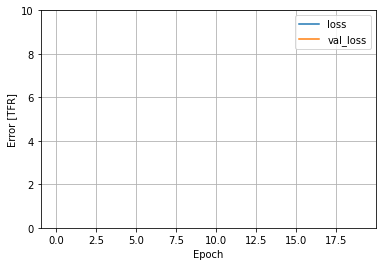

In [499]:
plot_loss(history)

In [500]:
test_results['linear_model'] = linear_model.evaluate(
    test_input_df, test_output_df, verbose=0)


In [501]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = linear_model.predict(test_input_df)

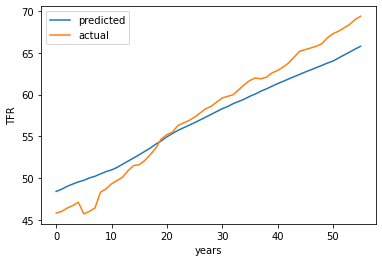

In [502]:
plot_test_data(test_predicted,test_output_np)

In [503]:
linear_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 11)               23        
 ion)                                                            
                                                                 
 dense_24 (Dense)            (None, 1)                 12        
                                                                 
Total params: 35
Trainable params: 12
Non-trainable params: 23
_________________________________________________________________


### Regression using DNN

In [505]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 11)               23        
 ion)                                                            
                                                                 
 dense_25 (Dense)            (None, 64)                768       
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,016
Trainable params: 4,993
Non-trainable params: 23
_________________________________________________________________


In [506]:
%%time
history = dnn_model.fit(
    input_df,
    output_df,
    validation_split=0.2,
    verbose=0, epochs=10)

CPU times: user 2.63 s, sys: 150 ms, total: 2.78 s
Wall time: 3.09 s


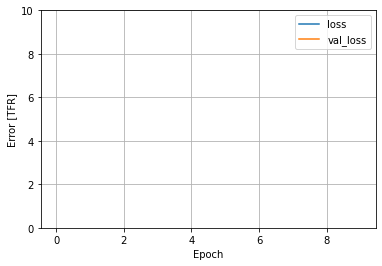

In [508]:
plot_loss(history)

In [509]:
test_results['dnn_model'] = dnn_model.evaluate(test_input_df, test_output_df, verbose=0)

In [510]:
test_output_np = test_output_df.to_numpy()
test_predicted = dnn_model.predict(test_input_df)

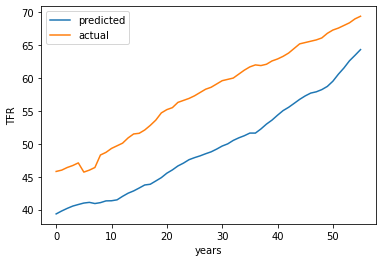

In [511]:
plot_test_data(test_predicted,test_output_np)


In [512]:
dnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 11)               23        
 ion)                                                            
                                                                 
 dense_25 (Dense)            (None, 64)                768       
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,016
Trainable params: 4,993
Non-trainable params: 23
_________________________________________________________________


### Results

In [513]:
test_results

{'dnn_model': 69.68310546875,
 'gradient_tree': 7.751605033874512,
 'linear_model': 4.612301349639893,
 'random_forest': 3.2312684059143066}

## Total Fertility Rate

### Preparing the data

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT         = 'children_per_woman'
country_to_test = 'india'
test_results = {"predict" : OUTPUT}

In [ ]:
datasets = [
            # "infant_mortality",
            "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            # create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            # create_n_yrs_old_csv("children_per_woman",n = 20),
            # create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            "20-24-Primary_fin",
            "20-24-Higher_Secondary_fin",
            "20-24-Lower_Secondary_fin",
            "20-24-female_Primary_fin",
            "20-24-female_Lower_Secondary_fin",
            "20-24-female_Higher_Secondary_fin",

            # "population",
            ]
get_countries_count(datasets)

Factor: life_expectancy                  count: 195
Factor: co2_emissions_percapita          count: 194
Factor: gini_index                       count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 20-24-Primary_fin                count: 202
Factor: 20-24-Higher_Secondary_fin       count: 202
Factor: 20-24-Lower_Secondary_fin        count: 202
Factor: 20-24-female_Primary_fin         count: 202
Factor: 20-24-female_Lower_Secondary_fin count: 202
Factor: 20-24-female_Higher_Secondary_fin count: 202


In [ ]:
# creating a list of all countries & years
# countries = find_common_countries(datasets=datasets,o_dataset=OUTPUT)
countries = poor_countries_list
countries.remove(country_to_test)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
# input_df.set_index(["country","year"], inplace=True)
# output_df           = input_df[["o_" + OUTPUT]]
# input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading life_expectancy
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading 20-24-Primary_fin
loading 20-24-Higher_Secondary_fin
loading 20-24-Lower_Secondary_fin
loading 20-24-female_Primary_fin
loading 20-24-female_Lower_Secondary_fin
loading 20-24-female_Higher_Secondary_fin


In [ ]:
input_df

,country,year,life_expectancy,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,20-24-Primary_fin,20-24-Higher_Secondary_fin,20-24-Lower_Secondary_fin,20-24-female_Primary_fin,20-24-female_Lower_Secondary_fin,20-24-female_Higher_Secondary_fin,o_children_per_woman
0,afghanistan,1960,45.0,0.0460,34.4,NaN,7.5,0.1,0.1,1.6,0.1,0.1,7.45
1,algeria,1960,52.4,0.5570,39.7,2170.0,18.3,0.3,10.1,8.1,4.1,0.1,7.52
2,angola,1960,46.3,0.1010,55.8,NaN,9.0,-0.0,2.1,3.2,1.3,0.1,7.48
3,bangladesh,1960,43.8,0.0461,24.9,463.0,22.5,1.1,11.4,10.6,2.9,0.1,6.73
4,benin,1960,44.8,0.0664,35.9,679.0,9.3,0.1,3.4,5.2,1.8,-0.0,6.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,tanzania,2015,65.1,0.2440,37.8,872.0,81.9,8.7,24.2,82.0,22.7,7.8,5.08
3412,togo,2015,62.4,0.3690,43.5,571.0,62.8,19.6,30.6,52.5,20.7,11.9,4.52
3413,tunisia,2015,77.0,2.6200,35.8,3860.0,97.8,52.2,90.3,97.2,89.1,55.3,2.22
3414,uganda,2015,63.9,0.1330,41.9,844.0,63.0,13.5,27.8,61.1,26.4,12.0,5.68


In [ ]:
countries = [country_to_test]
# countries = poor_countries_list
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)
test_input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
test_input_df.set_index(["country","year"], inplace=True)
test_output_df           = test_input_df[["o_" + OUTPUT]]
test_input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading life_expectancy
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading 20-24-Primary_fin
loading 20-24-Higher_Secondary_fin
loading 20-24-Lower_Secondary_fin
loading 20-24-female_Primary_fin
loading 20-24-female_Lower_Secondary_fin
loading 20-24-female_Higher_Secondary_fin


In [ ]:
test_input_df

life_expectancy  ...  20-24-female_Higher_Secondary_fin
country year                   ...                                   
india   1960             45.8  ...                               0.10
        1961             46.0  ...                               0.16
        1962             46.4  ...                               0.22
        1963             46.7  ...                               0.28
        1964             47.1  ...                               0.34
        1965             45.7  ...                               0.40
        1966             46.0  ...                               0.50
        1967             46.4  ...                               0.60
        1968             48.3  ...                               0.70
        1969             48.7  ...                               0.80
        1970             49.3  ...                               0.90
        1971             49.7  ...                               1.08
        1972             50.1  ...                               1.26
        1973             50.9  ...                               1.44
        1974             51.5  ...                               1.62
        1975             51.6  ...                               1.80
        1976             52.1  ...                               2.10
        1977             52.8  ...                               2.40
        1978             53.6  ...                               2.70
        1979             54.7  ...                               3.00
        1980             55.2  ...                               3.30
        1981             55.5  ...                               3.68
        1982             56.3  ...                               4.06
        1983             56.6  ...                               4.44
        1984             56.9  ...                               4.82
        1985             57.3  ...                               5.20
        1986             57.8  ...                               5.82
        1987             58.3  ...                               6.44
        1988             58.6  ...                               7.06
        1989             59.1  ...                               7.68
        1990             59.6  ...                               8.30
        1991             59.8  ...                               9.18
        1992             60.0  ...                              10.06
        1993             60.6  ...                              10.94
        1994             61.2  ...                              11.82
        1995             61.7  ...                              12.70
        1996             62.0  ...                              13.94
        1997             61.9  ...                              15.18
        1998             62.1  ...                              16.42
        1999             62.6  ...                              17.66
        2000             62.9  ...                              18.90
        2001             63.3  ...                              20.66
        2002             63.8  ...                              22.42
        2003             64.5  ...                              24.18
        2004             65.2  ...                              25.94
        2005             65.4  ...                              27.70
        2006             65.6  ...                              30.14
        2007             65.8  ...                              32.58
        2008             66.1  ...                              35.02
        2009             66.8  ...                              37.46
        2010             67.3  ...                              39.90
        2011             67.6  ...                              41.12
        2012             68.0  ...                              42.34
        2013             68.4  ...                              43.56
        2014             69.0  ...                              44.78
        2015            

In [ ]:
output_df

,,o_children_per_woman
country,year,
zambia,1960,7.12
uruguay,1960,2.88
paraguay,1960,6.50
niger,1960,7.45
burkina faso,1960,6.29
...,...,...
"micronesia, fed. sts.",2015,3.19
suriname,2015,2.40
guyana,2015,2.53


In [ ]:
input_df.isna().sum()

country                                0
year                                   0
life_expectancy                        0
co2_emissions_percapita                2
gini_index                             0
gdppercapita_us_infla_adjust         595
20-24-Primary_fin                      0
20-24-Higher_Secondary_fin             0
20-24-Lower_Secondary_fin              0
20-24-female_Primary_fin               0
20-24-female_Lower_Secondary_fin       0
20-24-female_Higher_Secondary_fin      0
o_children_per_woman                   0
dtype: int64

In [ ]:
for i in range(1,input_df.shape[1]+1):
  print(f"{i} => {input_df.dropna(thresh=i).shape}")

1 => (3416, 13)
2 => (3416, 13)
3 => (3416, 13)
4 => (3416, 13)
5 => (3416, 13)
6 => (3416, 13)
7 => (3416, 13)
8 => (3416, 13)
9 => (3416, 13)
10 => (3416, 13)
11 => (3416, 13)
12 => (3414, 13)
13 => (2821, 13)


In [ ]:
input_df.shape

(3416, 13)

### Finding optimal dataset

In [ ]:
for i in range(11,input_df.shape[1]+1):
  input_df_cpy = input_df.dropna(thresh=i).copy()
  input_df_cpy.set_index(["country","year"], inplace=True)
  output_df_cpy           = input_df_cpy[["o_" + OUTPUT]]
  input_df_cpy.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)
  # converting pandas to tensorFlow dataset
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df_cpy,output_df_cpy), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
  model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
  model.fit(x=train_ds)
  model.compile(metrics=["mse"])
  print(f"For Threshold = {i} size is {input_df_cpy.shape}")
  print(model.make_inspector().evaluation())

KeyError: ignored

In [ ]:
input_df.dropna(thresh=13, inplace=True)
input_df.set_index(["country","year"], inplace=True)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

### Random Forest

In [ ]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df.copy(),output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmp5s_j1g7h as temporary training directory
Starting reading the dataset
1/3 [=========>....................] - ETA: 0s
Dataset read in 0:00:00.258519
Training model
Model trained in 0:00:02.732191
Compiling model
3/3 [==============================] - 4s 2s/step


Evaluation(num_examples=2821, accuracy=None, loss=None, rmse=0.3034714937160371, ndcg=None, aucs=None)

In [ ]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(test_input_df.copy(),test_output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

evaluation = model.evaluate(test_ds, return_dict=True)

test_results['random_forest'] = evaluation['mse']

1/1 [==============================] - 0s 164ms/step - loss: 0.0000e+00 - mse: 0.5179


In [ ]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = model.predict(test_input_ds)

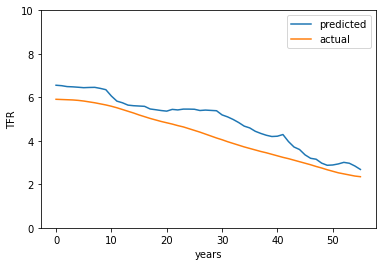

In [ ]:
plot_test_data(test_predicted,test_output_np)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=90)

In [ ]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (10):
	20-24-Higher_Secondary_fin
	20-24-Lower_Secondary_fin
	20-24-Primary_fin
	20-24-female_Higher_Secondary_fin
	20-24-female_Lower_Secondary_fin
	20-24-female_Primary_fin
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL" 10.645142 ################
    2.                 "20-24-Primary_fin"  8.031366 ##########
    3.           "co2_emissions_percapita"  7.036814 #########
    4.      "gdppercapita_us_infla_adjust"  6.687066 ########
    5.         "20-24-Lower_Secondary_fin"  6.539443 ########
    6.  

### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df.copy(),output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmp4j633p_5 as temporary training directory
Starting reading the dataset
1/3 [=========>....................] - ETA: 0s
Dataset read in 0:00:00.195564
Training model
Model trained in 0:00:02.957614
Compiling model
3/3 [==============================] - 3s 2s/step


Evaluation(num_examples=None, accuracy=None, loss=0.25625723600387573, rmse=0.25625723600387573, ndcg=None, aucs=None)

In [ ]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(test_input_df.copy(),test_output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

evaluation = model.evaluate(test_ds, return_dict=True)

test_results['gradient_tree'] = evaluation['mse']

1/1 [==============================] - 0s 149ms/step - loss: 0.0000e+00 - mse: 0.4327


In [ ]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = model.predict(test_input_ds)

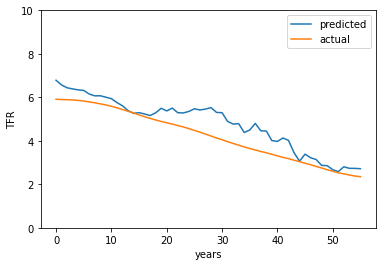

In [ ]:
plot_test_data(test_predicted,test_output_np)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (10):
	20-24-Higher_Secondary_fin
	20-24-Lower_Secondary_fin
	20-24-Primary_fin
	20-24-female_Higher_Secondary_fin
	20-24-female_Lower_Secondary_fin
	20-24-female_Primary_fin
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL"  4.677810 ################
    2.  "20-24-female_Lower_Secondary_fin"  4.096087 ##########
    3. "20-24-female_Higher_Secondary_fin"  3.757861 #######
    4.         "20-24-Lower_Secondary_fin"  3.719010 #######
    5.                 "20-24-Primary_fin"  3.708654 ###

### Linear Regression

In [ ]:
input_df.describe().transpose()[['mean', 'std']]

,mean,std
life_expectancy,57.814534,8.939448
co2_emissions_percapita,0.904196,2.223951
gini_index,43.231726,9.275423
gdppercapita_us_infla_adjust,1995.945055,3644.117565
20-24-Primary_fin,46.007090,25.674362
20-24-Higher_Secondary_fin,12.630301,15.992153
20-24-Lower_Secondary_fin,28.608196,21.333273
20-24-female_Primary_fin,39.498447,27.580815
20-24-female_Lower_Secondary_fin,23.694357,22.087956
20-24-female_Higher_Secondary_fin,10.588267,16.181680


In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
normalizer.adapt(np.array(input_df))

In [ ]:
first = np.array(input_df[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  52.4     0.56   39.7  2170.     18.3     0.3    10.1     8.1     4.1
     0.1 ]]

Normalized: [[-0.61 -0.16 -0.38  0.05 -1.08 -0.77 -0.87 -1.14 -0.89 -0.65]]


In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    keras.layers.Dense(units=1)
])

In [ ]:
linear_model.predict(input_df[:10])

array([[-1.6524365 ],
       [-2.4869828 ],
       [-1.8561382 ],
       [-0.03055594],
       [-0.97887236],
       [-1.9450185 ],
       [-0.9344017 ],
       [ 0.26739377],
       [-2.9504545 ],
       [-0.86928385]], dtype=float32)

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mse')

In [ ]:
input_df

,,life_expectancy,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,20-24-Primary_fin,20-24-Higher_Secondary_fin,20-24-Lower_Secondary_fin,20-24-female_Primary_fin,20-24-female_Lower_Secondary_fin,20-24-female_Higher_Secondary_fin
country,year,,,,,,,,,,
algeria,1960,52.4,0.55700,39.7,2170.0,18.3,0.3,10.1,8.1,4.1,0.1
bangladesh,1960,43.8,0.04610,24.9,463.0,22.5,1.1,11.4,10.6,2.9,0.1
benin,1960,44.8,0.06640,35.9,679.0,9.3,0.1,3.4,5.2,1.8,-0.0
brazil,1960,52.4,0.65000,44.3,2630.0,41.3,3.1,20.7,41.3,20.3,3.1
burkina faso,1960,39.5,0.00911,48.1,242.0,2.3,-0.0,1.3,0.9,0.4,-0.1
...,...,...,...,...,...,...,...,...,...,...,...
tanzania,2015,65.1,0.24400,37.8,872.0,81.9,8.7,24.2,82.0,22.7,7.8
togo,2015,62.4,0.36900,43.5,571.0,62.8,19.6,30.6,52.5,20.7,11.9
tunisia,2015,77.0,2.62000,35.8,3860.0,97.8,52.2,90.3,97.2,89.1,55.3


In [ ]:
%%time
history = linear_model.fit(
    input_df,
    output_df,
    epochs=20,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 7.85 s, sys: 464 ms, total: 8.32 s
Wall time: 11.1 s


In [ ]:
linear_model.layers[1].kernel

<tf.Variable 'dense_20/kernel:0' shape=(10, 1) dtype=float32, numpy=
array([[-0.45552242],
       [ 0.24277128],
       [ 0.21074261],
       [-0.07628386],
       [-0.8276122 ],
       [ 0.64883333],
       [ 1.13606   ],
       [ 0.28930753],
       [-1.9135463 ],
       [-0.77162623]], dtype=float32)>

In [ ]:
weights         = linear_model.layers[1].kernel.numpy().flatten()
features        = list(input_df.columns)
feature_weights = tuple(zip(features, weights)) 
for f,w in feature_weights:
  print(f"{f:<40}:{w}")

life_expectancy                         :-0.45552241802215576
co2_emissions_percapita                 :0.24277128279209137
gini_index                              :0.21074260771274567
gdppercapita_us_infla_adjust            :-0.07628385722637177
20-24-Primary_fin                       :-0.8276122212409973
20-24-Higher_Secondary_fin              :0.6488333344459534
20-24-Lower_Secondary_fin               :1.1360599994659424
20-24-female_Primary_fin                :0.28930753469467163
20-24-female_Lower_Secondary_fin        :-1.9135463237762451
20-24-female_Higher_Secondary_fin       :-0.7716262340545654


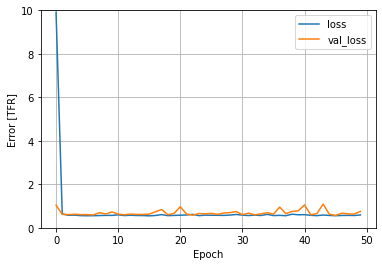

In [ ]:
plot_loss(history)

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_input_df, test_output_df, verbose=0)


In [ ]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = linear_model.predict(test_input_df)

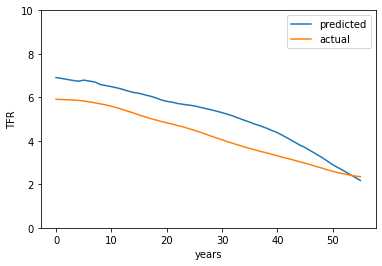

In [ ]:
plot_test_data(test_predicted,test_output_np)

In [ ]:
linear_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 32
Trainable params: 11
Non-trainable params: 21
_________________________________________________________________


### Regression using DNN

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_21 (Dense)            (None, 64)                704       
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    input_df,
    output_df,
    validation_split=0.2,
    verbose=0, epochs=10)

CPU times: user 9.8 s, sys: 667 ms, total: 10.5 s
Wall time: 8.54 s


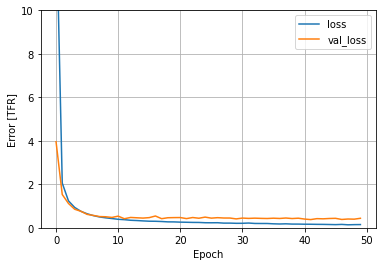

In [ ]:
plot_loss(history)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_input_df, test_output_df, verbose=0)

In [ ]:
test_output_np = test_output_df.to_numpy()
test_predicted = dnn_model.predict(test_input_df)

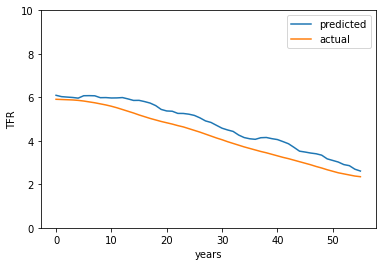

In [ ]:
plot_test_data(test_predicted,test_output_np)


In [ ]:
dnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_21 (Dense)            (None, 64)                704       
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


### Results

In [ ]:
test_results

{'dnn_model': 0.27829501032829285,
 'gradient_tree': 0.43273258209228516,
 'linear_model': 0.9101296663284302,
 'random_forest': 0.5178768038749695}

## Primary education Completion

### Preparing the data

In [539]:
PREDICT_FUTURE  = 0
OUTPUT         = '20-24-Primary_fin'
country_to_test = 'india'
test_results = {"predict" : OUTPUT}

In [540]:
datasets = [
            # "infant_mortality",
            "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            "gini_index",
            create_n_yrs_old_csv("gini_index",n = 10),
            # create_n_yrs_old_csv("gini_index",n = 20),
            "gdppercapita_us_infla_adjust",
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 10),
            # create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            # create_n_yrs_old_csv("infant_mortality",n = 20),
            
            "co2_emissions_percapita",
            create_n_yrs_old_csv("co2_emissions_percapita",n = 10),
            # create_n_yrs_old_csv("co2_emissions_percapita",n = 20),
            # create_n_yrs_old_csv("life_expectancy",n = 20),
            create_n_yrs_old_csv("child_mortality",n = 20),
            create_n_yrs_old_csv("children_per_woman",n = 20),
            
            # "20-24-Primary_fin",
            # "20-24-Lower_Secondary_fin",
            

            # create_n_yrs_old_csv("20-24-Primary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-Lower_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-Higher_Secondary_fin",n = 20),
            "population",
            # create_n_yrs_old_csv("20-24-female_Primary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Lower_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Higher_Secondary_fin",n = 20),
            # "gdp_growth",
            
            ]
get_countries_count(datasets)

Factor: life_expectancy                  count: 195
Factor: gini_index                       count: 195
Factor: 10_yrs_old_gini_index            count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 10_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: co2_emissions_percapita          count: 194
Factor: 10_yrs_old_co2_emissions_percapita count: 194
Factor: 20_yrs_old_child_mortality       count: 197
Factor: 20_yrs_old_children_per_woman    count: 202
Factor: population                       count: 197


In [541]:
# creating a list of all countries & years
# countries = find_common_countries(datasets=datasets,o_dataset=OUTPUT)
countries = poor_countries_list.copy()
countries.remove(country_to_test)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [542]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
# input_df.set_index(["country","year"], inplace=True)
# output_df           = input_df[["o_" + OUTPUT]]
# input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading life_expectancy
loading gini_index
loading 10_yrs_old_gini_index
loading gdppercapita_us_infla_adjust
loading 10_yrs_old_gdppercapita_us_infla_adjust
loading co2_emissions_percapita
loading 10_yrs_old_co2_emissions_percapita
loading 20_yrs_old_child_mortality
loading 20_yrs_old_children_per_woman
loading population


In [ ]:
input_df

In [586]:
countries = [country_to_test]
# countries = poor_countries_list
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)
test_input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
test_input_df.dropna(inplace=True)
test_input_df.set_index(["country","year"], inplace=True)
test_output_df           = test_input_df[["o_" + OUTPUT]]
test_input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading life_expectancy
loading gini_index
loading 10_yrs_old_gini_index
loading gdppercapita_us_infla_adjust
loading 10_yrs_old_gdppercapita_us_infla_adjust
loading co2_emissions_percapita
loading 10_yrs_old_co2_emissions_percapita
loading 20_yrs_old_child_mortality
loading 20_yrs_old_children_per_woman
loading population


In [587]:
test_input_df

life_expectancy  ...    population
country year                   ...              
india   1980             55.2  ...  6.990000e+08
        1981             55.5  ...  7.150000e+08
        1982             56.3  ...  7.320000e+08
        1983             56.6  ...  7.490000e+08
        1984             56.9  ...  7.670000e+08
        1985             57.3  ...  7.840000e+08
        1986             57.8  ...  8.020000e+08
        1987             58.3  ...  8.200000e+08
        1988             58.6  ...  8.370000e+08
        1989             59.1  ...  8.550000e+08
        1990             59.6  ...  8.730000e+08
        1991             59.8  ...  8.910000e+08
        1992             60.0  ...  9.090000e+08
        1993             60.6  ...  9.270000e+08
        1994             61.2  ...  9.460000e+08
        1995             61.7  ...  9.640000e+08
        1996             62.0  ...  9.820000e+08
        1997             61.9  ...  1.000000e+09
        1998             62.1  ...  1.020000e+09
        1999             62.6  ...  1.040000e+09
        2000             62.9  ...  1.060000e+09
        2001             63.3  ...  1.080000e+09
        2002             63.8  ...  1.090000e+09
        2003             64.5  ...  1.110000e+09
        2004             65.2  ...  1.130000e+09
        2005             65.4  ...  1.150000e+09
        2006             65.6  ...  1.170000e+09
        2007             65.8  ...  1.180000e+09
        2008             66.1  ...  1.200000e+09
        2009             66.8  ...  1.220000e+09
        2010             67.3  ...  1.230000e+09
        2011             67.6  ...  1.250000e+09
        2012             68.0  ...  1.270000e+09
        2013             68.4  ...  1.280000e+09
        2014             69.0  ...  1.300000e+09
        2015             69.4  ...  1.310000e+09

[36 rows x 10 columns]

In [ ]:
output_df

,,o_children_per_woman
country,year,
zambia,1960,7.12
uruguay,1960,2.88
paraguay,1960,6.50
niger,1960,7.45
burkina faso,1960,6.29
...,...,...
"micronesia, fed. sts.",2015,3.19
suriname,2015,2.40
guyana,2015,2.53


In [ ]:
input_df.isna().sum()

country                                0
year                                   0
life_expectancy                        0
co2_emissions_percapita                2
gini_index                             0
gdppercapita_us_infla_adjust         595
20-24-Primary_fin                      0
20-24-Higher_Secondary_fin             0
20-24-Lower_Secondary_fin              0
20-24-female_Primary_fin               0
20-24-female_Lower_Secondary_fin       0
20-24-female_Higher_Secondary_fin      0
o_children_per_woman                   0
dtype: int64

In [546]:
for i in range(1,input_df.shape[1]+1):
  print(f"{i} => {input_df.dropna(thresh=i).shape}")

1 => (3416, 13)
2 => (3416, 13)
3 => (3416, 13)
4 => (3416, 13)
5 => (3416, 13)
6 => (3416, 13)
7 => (3414, 13)
8 => (3169, 13)
9 => (2806, 13)
10 => (2618, 13)
11 => (2559, 13)
12 => (2034, 13)
13 => (1857, 13)


In [ ]:
input_df.shape

(3416, 13)

### Finding optimal dataset

In [547]:
for i in range(7,input_df.shape[1]+1):
  input_df_cpy = input_df.dropna(thresh=i).copy()
  input_df_cpy.set_index(["country","year"], inplace=True)
  output_df_cpy           = input_df_cpy[["o_" + OUTPUT]]
  input_df_cpy.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)
  # converting pandas to tensorFlow dataset
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df_cpy,output_df_cpy), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
  model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
  model.fit(x=train_ds)
  model.compile(metrics=["mse"])
  print(f"For Threshold = {i} size is {input_df_cpy.shape}")
  print(model.make_inspector().evaluation())

Use /tmp/tmp9fmdtji1 as temporary training directory
Starting reading the dataset
1/4 [======>.......................] - ETA: 0s
Dataset read in 0:00:00.332301
Training model
Model trained in 0:00:04.791320
Compiling model
4/4 [==============================] - 6s 2s/step
For Threshold = 7 size is (3414, 11)
Evaluation(num_examples=3414, accuracy=None, loss=None, rmse=4.106476801616605, ndcg=None, aucs=None)
Use /tmp/tmpac6mf9cp as temporary training directory
Starting reading the dataset
1/4 [======>.......................] - ETA: 0s
Dataset read in 0:00:00.239004
Training model
Model trained in 0:00:02.897281
Compiling model
4/4 [==============================] - 4s 1s/step
For Threshold = 8 size is (3169, 11)
Evaluation(num_examples=3169, accuracy=None, loss=None, rmse=4.044293319251173, ndcg=None, aucs=None)
Use /tmp/tmp28v5fl8a as temporary training directory
Starting reading the dataset
1/3 [=========>....................] - ETA: 0s
Dataset read in 0:00:00.198989
Training model
M

In [548]:
input_df.dropna(thresh=13, inplace=True)
input_df.set_index(["country","year"], inplace=True)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

### Random Forest

In [549]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df.copy(),output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpcjzszgge as temporary training directory
Starting reading the dataset
1/2 [==============>...............] - ETA: 0s
Dataset read in 0:00:00.173611
Training model
Model trained in 0:00:01.605321
Compiling model
2/2 [==============================] - 2s 2s/step


Evaluation(num_examples=1857, accuracy=None, loss=None, rmse=3.4733474306269723, ndcg=None, aucs=None)

In [550]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(test_input_df.copy(),test_output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

evaluation = model.evaluate(test_ds, return_dict=True)

test_results['random_forest'] = evaluation['mse']

1/1 [==============================] - 0s 161ms/step - loss: 0.0000e+00 - mse: 200.8755


In [551]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = model.predict(test_input_ds)

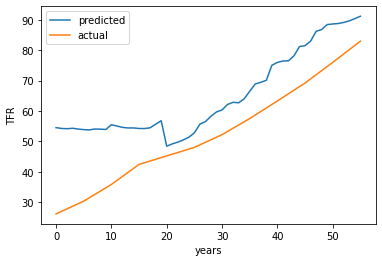

In [552]:
plot_test_data(test_predicted,test_output_np)

In [553]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=90)

In [554]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (10):
	10_yrs_old_co2_emissions_percapita
	10_yrs_old_gdppercapita_us_infla_adjust
	10_yrs_old_gini_index
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  9.731218 ################
    2. "10_yrs_old_gdppercapita_us_infla_adjust"  7.859282 ############
    3.                   "10_yrs_old_gini_index"  7.522660 ###########
    4.                              "gini_index"  7.412912 ###########
    5.                         "life_

### Gradient Tree

In [555]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df.copy(),output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpupa4jm_5 as temporary training directory
Starting reading the dataset
1/2 [==============>...............] - ETA: 0s
Dataset read in 0:00:00.183310
Training model
Model trained in 0:00:02.180930
Compiling model
2/2 [==============================] - 2s 2s/step


Evaluation(num_examples=None, accuracy=None, loss=2.967918634414673, rmse=2.967918634414673, ndcg=None, aucs=None)

In [556]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(test_input_df.copy(),test_output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

evaluation = model.evaluate(test_ds, return_dict=True)

test_results['gradient_tree'] = evaluation['mse']

1/1 [==============================] - 0s 153ms/step - loss: 0.0000e+00 - mse: 375.4367


In [557]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = model.predict(test_input_ds)

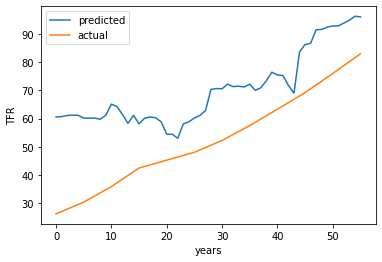

In [558]:
plot_test_data(test_predicted,test_output_np)

In [559]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [560]:
model.summary()

Model: "gradient_boosted_trees_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (10):
	10_yrs_old_co2_emissions_percapita
	10_yrs_old_gdppercapita_us_infla_adjust
	10_yrs_old_gini_index
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.589784 ################
    2.           "20_yrs_old_children_per_woman"  3.884536 ########
    3.                 "co2_emissions_percapita"  3.823058 #######
    4.                              "gini_index"  3.777752 ######
    5. "10_yrs_old_gdppercapita_u

### Removing rows in NaN

### Linear Regression

In [561]:
input_df.describe().transpose()[['mean', 'std']]

,mean,std
life_expectancy,6.071034e+01,8.396504e+00
gini_index,4.291152e+01,8.205382e+00
10_yrs_old_gini_index,4.369628e+01,9.200035e+00
gdppercapita_us_infla_adjust,2.265763e+03,3.746097e+03
10_yrs_old_gdppercapita_us_infla_adjust,1.927723e+03,3.641490e+03
co2_emissions_percapita,1.125697e+00,2.539931e+00
10_yrs_old_co2_emissions_percapita,8.809407e-01,2.148793e+00
20_yrs_old_child_mortality,1.813120e+02,8.055349e+01
20_yrs_old_children_per_woman,6.163366e+00,1.264409e+00
population,5.307314e+07,1.738134e+08


In [562]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [563]:
normalizer.adapt(np.array(input_df))

In [564]:
first = np.array(input_df[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[      58.7        40.1        39.9      3190.       2370.          3.46
         1.04      243.          7.52 19200000.  ]]

Normalized: [[-0.24 -0.34 -0.41  0.25  0.12  0.92  0.07  0.77  1.07 -0.19]]


In [565]:
linear_model = tf.keras.Sequential([
    normalizer,
    keras.layers.Dense(units=1)
])

In [566]:
linear_model.predict(input_df[:10])

array([[ 1.374311  ],
       [ 1.1912822 ],
       [ 0.40807766],
       [-0.43540356],
       [ 0.2658205 ],
       [ 0.90276456],
       [ 0.98431265],
       [-1.1603175 ],
       [ 0.6992431 ],
       [ 0.026829  ]], dtype=float32)

In [567]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mse')

In [568]:
input_df

,,life_expectancy,gini_index,10_yrs_old_gini_index,gdppercapita_us_infla_adjust,10_yrs_old_gdppercapita_us_infla_adjust,co2_emissions_percapita,10_yrs_old_co2_emissions_percapita,20_yrs_old_child_mortality,20_yrs_old_children_per_woman,population
country,year,,,,,,,,,,
algeria,1980,58.7,40.1,39.9,3190.0,2370.0,3.4600,1.0400,243.0,7.52,19200000.0
bangladesh,1980,53.2,25.3,20.1,448.0,512.0,0.0955,0.0593,260.0,6.73,79600000.0
benin,1980,52.7,42.6,41.7,775.0,758.0,0.1370,0.0969,311.0,6.28,3720000.0
brazil,1980,62.7,57.1,49.1,6440.0,3630.0,1.5400,0.9840,169.0,6.21,121000000.0
burkina faso,1980,48.6,48.5,48.3,315.0,276.0,0.0634,0.0254,343.0,6.29,6820000.0
...,...,...,...,...,...,...,...,...,...,...,...
tanzania,2015,65.1,37.8,39.3,872.0,637.0,0.2440,0.1400,157.0,5.88,51500000.0
togo,2015,62.4,43.5,43.0,571.0,468.0,0.3690,0.3070,135.0,5.76,7320000.0
tunisia,2015,77.0,35.8,38.3,3860.0,3130.0,2.6200,2.2100,42.8,2.61,11200000.0


In [608]:
%%time
history = linear_model.fit(
    input_df,
    output_df,
    epochs=500,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 55.2 s, sys: 2.99 s, total: 58.2 s
Wall time: 56.1 s


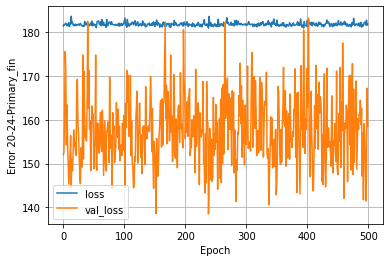

In [609]:
plot_loss(history)

In [602]:
weights         = linear_model.layers[1].kernel.numpy().flatten()
features        = list(input_df.columns)
feature_weights = list(zip(features, weights)) 

for f,w in sorted(feature_weights,key = lambda x: x[1]):
  print(f"{f:<40}:{w}")

20_yrs_old_child_mortality              :-12.861983299255371
20_yrs_old_children_per_woman           :-4.505788326263428
gdppercapita_us_infla_adjust            :-1.6364556550979614
10_yrs_old_gini_index                   :-1.6339577436447144
10_yrs_old_gdppercapita_us_infla_adjust :-1.511702060699463
10_yrs_old_co2_emissions_percapita      :0.9137111306190491
population                              :1.8830167055130005
gini_index                              :2.1103227138519287
life_expectancy                         :2.8753137588500977
co2_emissions_percapita                 :7.332895278930664


In [610]:
test_results['linear_model'] = linear_model.evaluate(
    test_input_df, test_output_df, verbose=0)


In [589]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = linear_model.predict(test_input_df)

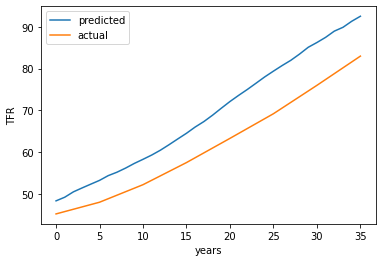

In [590]:
plot_test_data(test_predicted,test_output_np)

In [576]:
linear_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_28 (Dense)            (None, 1)                 11        
                                                                 
Total params: 32
Trainable params: 11
Non-trainable params: 21
_________________________________________________________________


### Regression using DNN

In [577]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_29 (Dense)            (None, 64)                704       
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


In [578]:
%%time
history = dnn_model.fit(
    input_df,
    output_df,
    validation_split=0.2,
    verbose=0, epochs=10)

CPU times: user 2.01 s, sys: 102 ms, total: 2.12 s
Wall time: 1.86 s


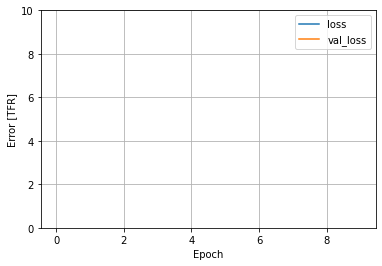

In [579]:
plot_loss(history)

In [591]:
test_results['dnn_model'] = dnn_model.evaluate(test_input_df, test_output_df, verbose=0)

In [592]:
test_output_np = test_output_df.to_numpy()
test_predicted = dnn_model.predict(test_input_df)

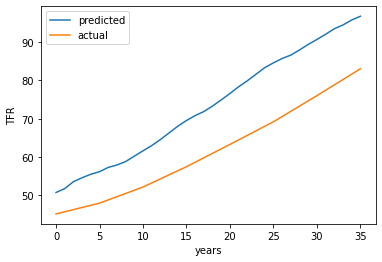

In [593]:
plot_test_data(test_predicted,test_output_np)


In [583]:
dnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_29 (Dense)            (None, 64)                704       
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


### Results

In [611]:
test_results

{'dnn_model': 145.8124237060547,
 'gradient_tree': 375.4366760253906,
 'linear_model': 74.06234741210938,
 'predict': '20-24-Primary_fin',
 'random_forest': 200.87548828125}

## Lower Secondary Education Completion

### Preparing the data

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT         = '20-24-Lower_Secondary_fin'
country_to_test = 'india'
test_results = {"predict" : OUTPUT}

In [ ]:
datasets = [
            # "infant_mortality",
            "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            # "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            # create_n_yrs_old_csv("infant_mortality",n = 20),
            create_n_yrs_old_csv("gini_index",n = 10),
            # create_n_yrs_old_csv("co2_emissions_percapita",n = 10),
            create_n_yrs_old_csv("life_expectancy",n = 20),
            create_n_yrs_old_csv("child_mortality",n = 20),
            create_n_yrs_old_csv("children_per_woman",n = 20),
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 10),
            # "20-24-Primary_fin",
            # "20-24-Lower_Secondary_fin",
            # "life_expectancy",
            # "children_per_woman",

            create_n_yrs_old_csv("20-24-Primary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-Lower_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-Higher_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Primary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Lower_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Higher_Secondary_fin",n = 20),
            # "gdp_growth",
            
            # create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            # rate_of_dropout("20-24-Primary_OL",5),
            # "20-24-In_Primary_OL",
            # "20-24-Primary_OL",
            # "20-24-Lower_Secondary_OL",
            "population",
            # "20-24_female-In_Primary_OL",
            # "20-24_female-Primary_OL",
            # "20-24_female-Lower_Secondary_OL",
            ]
get_countries_count(datasets)

Factor: life_expectancy                  count: 195
Factor: gini_index                       count: 195
Factor: 10_yrs_old_gini_index            count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 10_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: co2_emissions_percapita          count: 194
Factor: 10_yrs_old_co2_emissions_percapita count: 194
Factor: 20_yrs_old_child_mortality       count: 197
Factor: 20_yrs_old_children_per_woman    count: 202
Factor: population                       count: 197


In [ ]:
# creating a list of all countries & years
# countries = find_common_countries(datasets=datasets,o_dataset=OUTPUT)
countries = poor_countries_list.copy()
countries.remove(country_to_test)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
# input_df.set_index(["country","year"], inplace=True)
# output_df           = input_df[["o_" + OUTPUT]]
# input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading life_expectancy
loading gini_index
loading 10_yrs_old_gini_index
loading gdppercapita_us_infla_adjust
loading 10_yrs_old_gdppercapita_us_infla_adjust
loading co2_emissions_percapita
loading 10_yrs_old_co2_emissions_percapita
loading 20_yrs_old_child_mortality
loading 20_yrs_old_children_per_woman
loading population


In [ ]:
input_df

In [ ]:
countries = [country_to_test]
# countries = poor_countries_list
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)
test_input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
test_input_df.dropna(inplace=True)
test_input_df.set_index(["country","year"], inplace=True)
test_output_df           = test_input_df[["o_" + OUTPUT]]
test_input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading life_expectancy
loading gini_index
loading 10_yrs_old_gini_index
loading gdppercapita_us_infla_adjust
loading 10_yrs_old_gdppercapita_us_infla_adjust
loading co2_emissions_percapita
loading 10_yrs_old_co2_emissions_percapita
loading 20_yrs_old_child_mortality
loading 20_yrs_old_children_per_woman
loading population


In [ ]:
test_input_df

life_expectancy  ...    population
country year                   ...              
india   1980             55.2  ...  6.990000e+08
        1981             55.5  ...  7.150000e+08
        1982             56.3  ...  7.320000e+08
        1983             56.6  ...  7.490000e+08
        1984             56.9  ...  7.670000e+08
        1985             57.3  ...  7.840000e+08
        1986             57.8  ...  8.020000e+08
        1987             58.3  ...  8.200000e+08
        1988             58.6  ...  8.370000e+08
        1989             59.1  ...  8.550000e+08
        1990             59.6  ...  8.730000e+08
        1991             59.8  ...  8.910000e+08
        1992             60.0  ...  9.090000e+08
        1993             60.6  ...  9.270000e+08
        1994             61.2  ...  9.460000e+08
        1995             61.7  ...  9.640000e+08
        1996             62.0  ...  9.820000e+08
        1997             61.9  ...  1.000000e+09
        1998             62.1  ...  1.020000e+09
        1999             62.6  ...  1.040000e+09
        2000             62.9  ...  1.060000e+09
        2001             63.3  ...  1.080000e+09
        2002             63.8  ...  1.090000e+09
        2003             64.5  ...  1.110000e+09
        2004             65.2  ...  1.130000e+09
        2005             65.4  ...  1.150000e+09
        2006             65.6  ...  1.170000e+09
        2007             65.8  ...  1.180000e+09
        2008             66.1  ...  1.200000e+09
        2009             66.8  ...  1.220000e+09
        2010             67.3  ...  1.230000e+09
        2011             67.6  ...  1.250000e+09
        2012             68.0  ...  1.270000e+09
        2013             68.4  ...  1.280000e+09
        2014             69.0  ...  1.300000e+09
        2015             69.4  ...  1.310000e+09

[36 rows x 10 columns]

In [ ]:
output_df

,,o_children_per_woman
country,year,
zambia,1960,7.12
uruguay,1960,2.88
paraguay,1960,6.50
niger,1960,7.45
burkina faso,1960,6.29
...,...,...
"micronesia, fed. sts.",2015,3.19
suriname,2015,2.40
guyana,2015,2.53


In [ ]:
input_df.isna().sum()

country                                0
year                                   0
life_expectancy                        0
co2_emissions_percapita                2
gini_index                             0
gdppercapita_us_infla_adjust         595
20-24-Primary_fin                      0
20-24-Higher_Secondary_fin             0
20-24-Lower_Secondary_fin              0
20-24-female_Primary_fin               0
20-24-female_Lower_Secondary_fin       0
20-24-female_Higher_Secondary_fin      0
o_children_per_woman                   0
dtype: int64

In [ ]:
for i in range(1,input_df.shape[1]+1):
  print(f"{i} => {input_df.dropna(thresh=i).shape}")

1 => (3416, 13)
2 => (3416, 13)
3 => (3416, 13)
4 => (3416, 13)
5 => (3416, 13)
6 => (3416, 13)
7 => (3414, 13)
8 => (3169, 13)
9 => (2806, 13)
10 => (2618, 13)
11 => (2559, 13)
12 => (2034, 13)
13 => (1857, 13)


In [ ]:
input_df.shape

(3416, 13)

### Finding optimal dataset

In [ ]:
for i in range(7,input_df.shape[1]+1):
  input_df_cpy = input_df.dropna(thresh=i).copy()
  input_df_cpy.set_index(["country","year"], inplace=True)
  output_df_cpy           = input_df_cpy[["o_" + OUTPUT]]
  input_df_cpy.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)
  # converting pandas to tensorFlow dataset
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df_cpy,output_df_cpy), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
  model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
  model.fit(x=train_ds)
  model.compile(metrics=["mse"])
  print(f"For Threshold = {i} size is {input_df_cpy.shape}")
  print(model.make_inspector().evaluation())

Use /tmp/tmp9fmdtji1 as temporary training directory
Starting reading the dataset
1/4 [======>.......................] - ETA: 0s
Dataset read in 0:00:00.332301
Training model
Model trained in 0:00:04.791320
Compiling model
4/4 [==============================] - 6s 2s/step
For Threshold = 7 size is (3414, 11)
Evaluation(num_examples=3414, accuracy=None, loss=None, rmse=4.106476801616605, ndcg=None, aucs=None)
Use /tmp/tmpac6mf9cp as temporary training directory
Starting reading the dataset
1/4 [======>.......................] - ETA: 0s
Dataset read in 0:00:00.239004
Training model
Model trained in 0:00:02.897281
Compiling model
4/4 [==============================] - 4s 1s/step
For Threshold = 8 size is (3169, 11)
Evaluation(num_examples=3169, accuracy=None, loss=None, rmse=4.044293319251173, ndcg=None, aucs=None)
Use /tmp/tmp28v5fl8a as temporary training directory
Starting reading the dataset
1/3 [=========>....................] - ETA: 0s
Dataset read in 0:00:00.198989
Training model
M

In [ ]:
input_df.dropna(thresh=13, inplace=True)
input_df.set_index(["country","year"], inplace=True)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

### Random Forest

In [ ]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df.copy(),output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpcjzszgge as temporary training directory
Starting reading the dataset
1/2 [==============>...............] - ETA: 0s
Dataset read in 0:00:00.173611
Training model
Model trained in 0:00:01.605321
Compiling model
2/2 [==============================] - 2s 2s/step


Evaluation(num_examples=1857, accuracy=None, loss=None, rmse=3.4733474306269723, ndcg=None, aucs=None)

In [ ]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(test_input_df.copy(),test_output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

evaluation = model.evaluate(test_ds, return_dict=True)

test_results['random_forest'] = evaluation['mse']

1/1 [==============================] - 0s 161ms/step - loss: 0.0000e+00 - mse: 200.8755


In [ ]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = model.predict(test_input_ds)

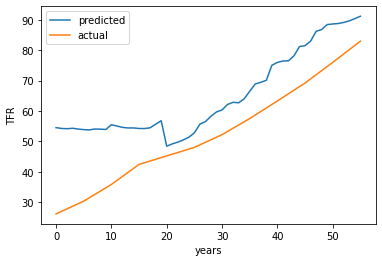

In [ ]:
plot_test_data(test_predicted,test_output_np)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=90)

In [ ]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (10):
	10_yrs_old_co2_emissions_percapita
	10_yrs_old_gdppercapita_us_infla_adjust
	10_yrs_old_gini_index
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  9.731218 ################
    2. "10_yrs_old_gdppercapita_us_infla_adjust"  7.859282 ############
    3.                   "10_yrs_old_gini_index"  7.522660 ###########
    4.                              "gini_index"  7.412912 ###########
    5.                         "life_

### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df.copy(),output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpupa4jm_5 as temporary training directory
Starting reading the dataset
1/2 [==============>...............] - ETA: 0s
Dataset read in 0:00:00.183310
Training model
Model trained in 0:00:02.180930
Compiling model
2/2 [==============================] - 2s 2s/step


Evaluation(num_examples=None, accuracy=None, loss=2.967918634414673, rmse=2.967918634414673, ndcg=None, aucs=None)

In [ ]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(test_input_df.copy(),test_output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

evaluation = model.evaluate(test_ds, return_dict=True)

test_results['gradient_tree'] = evaluation['mse']

1/1 [==============================] - 0s 153ms/step - loss: 0.0000e+00 - mse: 375.4367


In [ ]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = model.predict(test_input_ds)

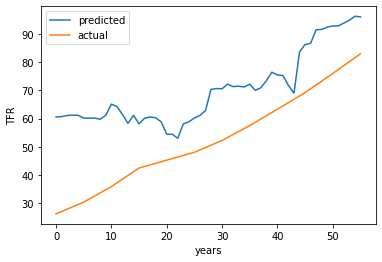

In [ ]:
plot_test_data(test_predicted,test_output_np)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (10):
	10_yrs_old_co2_emissions_percapita
	10_yrs_old_gdppercapita_us_infla_adjust
	10_yrs_old_gini_index
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.589784 ################
    2.           "20_yrs_old_children_per_woman"  3.884536 ########
    3.                 "co2_emissions_percapita"  3.823058 #######
    4.                              "gini_index"  3.777752 ######
    5. "10_yrs_old_gdppercapita_u

### Removing rows in NaN

### Linear Regression

In [ ]:
input_df.describe().transpose()[['mean', 'std']]

,mean,std
life_expectancy,6.071034e+01,8.396504e+00
gini_index,4.291152e+01,8.205382e+00
10_yrs_old_gini_index,4.369628e+01,9.200035e+00
gdppercapita_us_infla_adjust,2.265763e+03,3.746097e+03
10_yrs_old_gdppercapita_us_infla_adjust,1.927723e+03,3.641490e+03
co2_emissions_percapita,1.125697e+00,2.539931e+00
10_yrs_old_co2_emissions_percapita,8.809407e-01,2.148793e+00
20_yrs_old_child_mortality,1.813120e+02,8.055349e+01
20_yrs_old_children_per_woman,6.163366e+00,1.264409e+00
population,5.307314e+07,1.738134e+08


In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
normalizer.adapt(np.array(input_df))

In [ ]:
first = np.array(input_df[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[      58.7        40.1        39.9      3190.       2370.          3.46
         1.04      243.          7.52 19200000.  ]]

Normalized: [[-0.24 -0.34 -0.41  0.25  0.12  0.92  0.07  0.77  1.07 -0.19]]


In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    keras.layers.Dense(units=1)
])

In [ ]:
linear_model.predict(input_df[:10])

array([[ 1.374311  ],
       [ 1.1912822 ],
       [ 0.40807766],
       [-0.43540356],
       [ 0.2658205 ],
       [ 0.90276456],
       [ 0.98431265],
       [-1.1603175 ],
       [ 0.6992431 ],
       [ 0.026829  ]], dtype=float32)

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mse')

In [ ]:
input_df

,,life_expectancy,gini_index,10_yrs_old_gini_index,gdppercapita_us_infla_adjust,10_yrs_old_gdppercapita_us_infla_adjust,co2_emissions_percapita,10_yrs_old_co2_emissions_percapita,20_yrs_old_child_mortality,20_yrs_old_children_per_woman,population
country,year,,,,,,,,,,
algeria,1980,58.7,40.1,39.9,3190.0,2370.0,3.4600,1.0400,243.0,7.52,19200000.0
bangladesh,1980,53.2,25.3,20.1,448.0,512.0,0.0955,0.0593,260.0,6.73,79600000.0
benin,1980,52.7,42.6,41.7,775.0,758.0,0.1370,0.0969,311.0,6.28,3720000.0
brazil,1980,62.7,57.1,49.1,6440.0,3630.0,1.5400,0.9840,169.0,6.21,121000000.0
burkina faso,1980,48.6,48.5,48.3,315.0,276.0,0.0634,0.0254,343.0,6.29,6820000.0
...,...,...,...,...,...,...,...,...,...,...,...
tanzania,2015,65.1,37.8,39.3,872.0,637.0,0.2440,0.1400,157.0,5.88,51500000.0
togo,2015,62.4,43.5,43.0,571.0,468.0,0.3690,0.3070,135.0,5.76,7320000.0
tunisia,2015,77.0,35.8,38.3,3860.0,3130.0,2.6200,2.2100,42.8,2.61,11200000.0


In [ ]:
%%time
history = linear_model.fit(
    input_df,
    output_df,
    epochs=500,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 55.2 s, sys: 2.99 s, total: 58.2 s
Wall time: 56.1 s


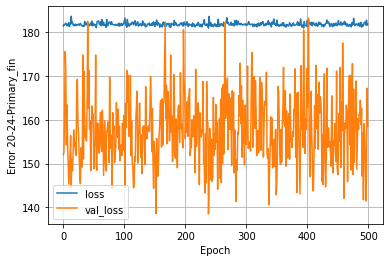

In [ ]:
plot_loss(history)

In [ ]:
weights         = linear_model.layers[1].kernel.numpy().flatten()
features        = list(input_df.columns)
feature_weights = list(zip(features, weights)) 

for f,w in sorted(feature_weights,key = lambda x: x[1]):
  print(f"{f:<40}:{w}")

20_yrs_old_child_mortality              :-12.861983299255371
20_yrs_old_children_per_woman           :-4.505788326263428
gdppercapita_us_infla_adjust            :-1.6364556550979614
10_yrs_old_gini_index                   :-1.6339577436447144
10_yrs_old_gdppercapita_us_infla_adjust :-1.511702060699463
10_yrs_old_co2_emissions_percapita      :0.9137111306190491
population                              :1.8830167055130005
gini_index                              :2.1103227138519287
life_expectancy                         :2.8753137588500977
co2_emissions_percapita                 :7.332895278930664


In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_input_df, test_output_df, verbose=0)


In [ ]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = linear_model.predict(test_input_df)

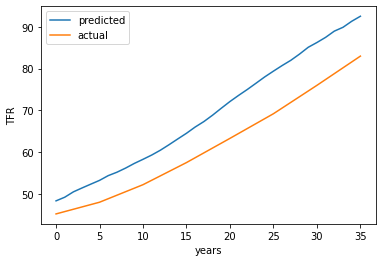

In [ ]:
plot_test_data(test_predicted,test_output_np)

In [ ]:
linear_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_28 (Dense)            (None, 1)                 11        
                                                                 
Total params: 32
Trainable params: 11
Non-trainable params: 21
_________________________________________________________________


### Regression using DNN

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_29 (Dense)            (None, 64)                704       
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    input_df,
    output_df,
    validation_split=0.2,
    verbose=0, epochs=10)

CPU times: user 2.01 s, sys: 102 ms, total: 2.12 s
Wall time: 1.86 s


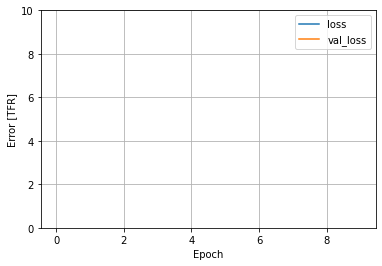

In [ ]:
plot_loss(history)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_input_df, test_output_df, verbose=0)

In [ ]:
test_output_np = test_output_df.to_numpy()
test_predicted = dnn_model.predict(test_input_df)

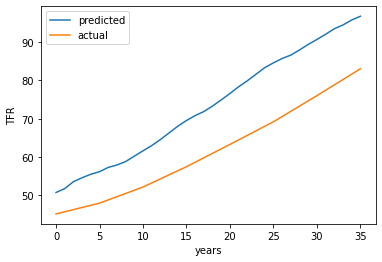

In [ ]:
plot_test_data(test_predicted,test_output_np)


In [ ]:
dnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_29 (Dense)            (None, 64)                704       
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


### Results

In [ ]:
test_results

{'dnn_model': 145.8124237060547,
 'gradient_tree': 375.4366760253906,
 'linear_model': 74.06234741210938,
 'predict': '20-24-Primary_fin',
 'random_forest': 200.87548828125}

## GDP per capita

### Preparing the data

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT         = 'gdppercapita_us_infla_adjust'
country_to_test = 'india'
test_results = {"predict" : OUTPUT}

In [ ]:
datasets = [
            # "infant_mortality",
             "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            # "co2_emissions_percapita",
            # "gini_index",
            create_n_yrs_old_csv("infant_mortality",n = 25),
            #  create_n_yrs_old_csv("life_expectancy",n = 20),
            create_n_yrs_old_csv("child_mortality",n = 20),
            create_n_yrs_old_csv("children_per_woman",n = 25),
            # create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            # create_n_yrs_old_csv("20-24-In_Primary_OL",n = 20),
            # create_n_yrs_old_csv("20-24-Primary_OL",n = 20),
            # create_n_yrs_old_csv("20-24-Lower_Secondary_OL",n = 20),
            "20-24-Primary_fin",
            "20-24-Higher_Secondary_fin",
            "20-24-Lower_Secondary_fin",
            "20-24-female_Primary_fin",
            "20-24-female_Lower_Secondary_fin",
            "20-24-female_Higher_Secondary_fin",
            "population",
            ]
get_countries_count(datasets)

Factor: life_expectancy                  count: 195
Factor: gini_index                       count: 195
Factor: 10_yrs_old_gini_index            count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 10_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: co2_emissions_percapita          count: 194
Factor: 10_yrs_old_co2_emissions_percapita count: 194
Factor: 20_yrs_old_child_mortality       count: 197
Factor: 20_yrs_old_children_per_woman    count: 202
Factor: population                       count: 197


In [ ]:
# creating a list of all countries & years
# countries = find_common_countries(datasets=datasets,o_dataset=OUTPUT)
countries = poor_countries_list.copy()
countries.remove(country_to_test)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
# input_df.set_index(["country","year"], inplace=True)
# output_df           = input_df[["o_" + OUTPUT]]
# input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading life_expectancy
loading gini_index
loading 10_yrs_old_gini_index
loading gdppercapita_us_infla_adjust
loading 10_yrs_old_gdppercapita_us_infla_adjust
loading co2_emissions_percapita
loading 10_yrs_old_co2_emissions_percapita
loading 20_yrs_old_child_mortality
loading 20_yrs_old_children_per_woman
loading population


In [ ]:
input_df

In [ ]:
countries = [country_to_test]
# countries = poor_countries_list
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)
test_input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
test_input_df.dropna(inplace=True)
test_input_df.set_index(["country","year"], inplace=True)
test_output_df           = test_input_df[["o_" + OUTPUT]]
test_input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading life_expectancy
loading gini_index
loading 10_yrs_old_gini_index
loading gdppercapita_us_infla_adjust
loading 10_yrs_old_gdppercapita_us_infla_adjust
loading co2_emissions_percapita
loading 10_yrs_old_co2_emissions_percapita
loading 20_yrs_old_child_mortality
loading 20_yrs_old_children_per_woman
loading population


In [ ]:
test_input_df

life_expectancy  ...    population
country year                   ...              
india   1980             55.2  ...  6.990000e+08
        1981             55.5  ...  7.150000e+08
        1982             56.3  ...  7.320000e+08
        1983             56.6  ...  7.490000e+08
        1984             56.9  ...  7.670000e+08
        1985             57.3  ...  7.840000e+08
        1986             57.8  ...  8.020000e+08
        1987             58.3  ...  8.200000e+08
        1988             58.6  ...  8.370000e+08
        1989             59.1  ...  8.550000e+08
        1990             59.6  ...  8.730000e+08
        1991             59.8  ...  8.910000e+08
        1992             60.0  ...  9.090000e+08
        1993             60.6  ...  9.270000e+08
        1994             61.2  ...  9.460000e+08
        1995             61.7  ...  9.640000e+08
        1996             62.0  ...  9.820000e+08
        1997             61.9  ...  1.000000e+09
        1998             62.1  ...  1.020000e+09
        1999             62.6  ...  1.040000e+09
        2000             62.9  ...  1.060000e+09
        2001             63.3  ...  1.080000e+09
        2002             63.8  ...  1.090000e+09
        2003             64.5  ...  1.110000e+09
        2004             65.2  ...  1.130000e+09
        2005             65.4  ...  1.150000e+09
        2006             65.6  ...  1.170000e+09
        2007             65.8  ...  1.180000e+09
        2008             66.1  ...  1.200000e+09
        2009             66.8  ...  1.220000e+09
        2010             67.3  ...  1.230000e+09
        2011             67.6  ...  1.250000e+09
        2012             68.0  ...  1.270000e+09
        2013             68.4  ...  1.280000e+09
        2014             69.0  ...  1.300000e+09
        2015             69.4  ...  1.310000e+09

[36 rows x 10 columns]

In [ ]:
output_df

,,o_children_per_woman
country,year,
zambia,1960,7.12
uruguay,1960,2.88
paraguay,1960,6.50
niger,1960,7.45
burkina faso,1960,6.29
...,...,...
"micronesia, fed. sts.",2015,3.19
suriname,2015,2.40
guyana,2015,2.53


In [ ]:
input_df.isna().sum()

country                                0
year                                   0
life_expectancy                        0
co2_emissions_percapita                2
gini_index                             0
gdppercapita_us_infla_adjust         595
20-24-Primary_fin                      0
20-24-Higher_Secondary_fin             0
20-24-Lower_Secondary_fin              0
20-24-female_Primary_fin               0
20-24-female_Lower_Secondary_fin       0
20-24-female_Higher_Secondary_fin      0
o_children_per_woman                   0
dtype: int64

In [ ]:
for i in range(1,input_df.shape[1]+1):
  print(f"{i} => {input_df.dropna(thresh=i).shape}")

1 => (3416, 13)
2 => (3416, 13)
3 => (3416, 13)
4 => (3416, 13)
5 => (3416, 13)
6 => (3416, 13)
7 => (3414, 13)
8 => (3169, 13)
9 => (2806, 13)
10 => (2618, 13)
11 => (2559, 13)
12 => (2034, 13)
13 => (1857, 13)


In [ ]:
input_df.shape

(3416, 13)

### Finding optimal dataset

In [ ]:
for i in range(7,input_df.shape[1]+1):
  input_df_cpy = input_df.dropna(thresh=i).copy()
  input_df_cpy.set_index(["country","year"], inplace=True)
  output_df_cpy           = input_df_cpy[["o_" + OUTPUT]]
  input_df_cpy.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)
  # converting pandas to tensorFlow dataset
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df_cpy,output_df_cpy), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
  model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
  model.fit(x=train_ds)
  model.compile(metrics=["mse"])
  print(f"For Threshold = {i} size is {input_df_cpy.shape}")
  print(model.make_inspector().evaluation())

Use /tmp/tmp9fmdtji1 as temporary training directory
Starting reading the dataset
1/4 [======>.......................] - ETA: 0s
Dataset read in 0:00:00.332301
Training model
Model trained in 0:00:04.791320
Compiling model
4/4 [==============================] - 6s 2s/step
For Threshold = 7 size is (3414, 11)
Evaluation(num_examples=3414, accuracy=None, loss=None, rmse=4.106476801616605, ndcg=None, aucs=None)
Use /tmp/tmpac6mf9cp as temporary training directory
Starting reading the dataset
1/4 [======>.......................] - ETA: 0s
Dataset read in 0:00:00.239004
Training model
Model trained in 0:00:02.897281
Compiling model
4/4 [==============================] - 4s 1s/step
For Threshold = 8 size is (3169, 11)
Evaluation(num_examples=3169, accuracy=None, loss=None, rmse=4.044293319251173, ndcg=None, aucs=None)
Use /tmp/tmp28v5fl8a as temporary training directory
Starting reading the dataset
1/3 [=========>....................] - ETA: 0s
Dataset read in 0:00:00.198989
Training model
M

In [ ]:
input_df.dropna(thresh=13, inplace=True)
input_df.set_index(["country","year"], inplace=True)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

### Random Forest

In [ ]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df.copy(),output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpcjzszgge as temporary training directory
Starting reading the dataset
1/2 [==============>...............] - ETA: 0s
Dataset read in 0:00:00.173611
Training model
Model trained in 0:00:01.605321
Compiling model
2/2 [==============================] - 2s 2s/step


Evaluation(num_examples=1857, accuracy=None, loss=None, rmse=3.4733474306269723, ndcg=None, aucs=None)

In [ ]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(test_input_df.copy(),test_output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

evaluation = model.evaluate(test_ds, return_dict=True)

test_results['random_forest'] = evaluation['mse']

1/1 [==============================] - 0s 161ms/step - loss: 0.0000e+00 - mse: 200.8755


In [ ]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = model.predict(test_input_ds)

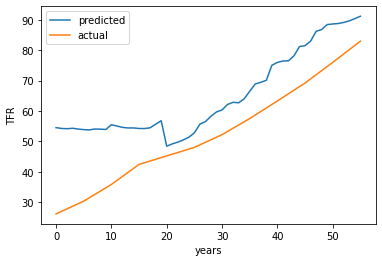

In [ ]:
plot_test_data(test_predicted,test_output_np)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=90)

In [ ]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (10):
	10_yrs_old_co2_emissions_percapita
	10_yrs_old_gdppercapita_us_infla_adjust
	10_yrs_old_gini_index
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  9.731218 ################
    2. "10_yrs_old_gdppercapita_us_infla_adjust"  7.859282 ############
    3.                   "10_yrs_old_gini_index"  7.522660 ###########
    4.                              "gini_index"  7.412912 ###########
    5.                         "life_

### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df.copy(),output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpupa4jm_5 as temporary training directory
Starting reading the dataset
1/2 [==============>...............] - ETA: 0s
Dataset read in 0:00:00.183310
Training model
Model trained in 0:00:02.180930
Compiling model
2/2 [==============================] - 2s 2s/step


Evaluation(num_examples=None, accuracy=None, loss=2.967918634414673, rmse=2.967918634414673, ndcg=None, aucs=None)

In [ ]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(test_input_df.copy(),test_output_df.copy()), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

evaluation = model.evaluate(test_ds, return_dict=True)

test_results['gradient_tree'] = evaluation['mse']

1/1 [==============================] - 0s 153ms/step - loss: 0.0000e+00 - mse: 375.4367


In [ ]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = model.predict(test_input_ds)

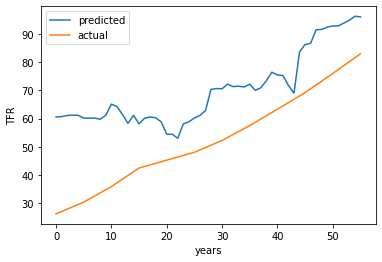

In [ ]:
plot_test_data(test_predicted,test_output_np)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (10):
	10_yrs_old_co2_emissions_percapita
	10_yrs_old_gdppercapita_us_infla_adjust
	10_yrs_old_gini_index
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.589784 ################
    2.           "20_yrs_old_children_per_woman"  3.884536 ########
    3.                 "co2_emissions_percapita"  3.823058 #######
    4.                              "gini_index"  3.777752 ######
    5. "10_yrs_old_gdppercapita_u

### Removing rows in NaN

### Linear Regression

In [ ]:
input_df.describe().transpose()[['mean', 'std']]

,mean,std
life_expectancy,6.071034e+01,8.396504e+00
gini_index,4.291152e+01,8.205382e+00
10_yrs_old_gini_index,4.369628e+01,9.200035e+00
gdppercapita_us_infla_adjust,2.265763e+03,3.746097e+03
10_yrs_old_gdppercapita_us_infla_adjust,1.927723e+03,3.641490e+03
co2_emissions_percapita,1.125697e+00,2.539931e+00
10_yrs_old_co2_emissions_percapita,8.809407e-01,2.148793e+00
20_yrs_old_child_mortality,1.813120e+02,8.055349e+01
20_yrs_old_children_per_woman,6.163366e+00,1.264409e+00
population,5.307314e+07,1.738134e+08


In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
normalizer.adapt(np.array(input_df))

In [ ]:
first = np.array(input_df[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[      58.7        40.1        39.9      3190.       2370.          3.46
         1.04      243.          7.52 19200000.  ]]

Normalized: [[-0.24 -0.34 -0.41  0.25  0.12  0.92  0.07  0.77  1.07 -0.19]]


In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    keras.layers.Dense(units=1)
])

In [ ]:
linear_model.predict(input_df[:10])

array([[ 1.374311  ],
       [ 1.1912822 ],
       [ 0.40807766],
       [-0.43540356],
       [ 0.2658205 ],
       [ 0.90276456],
       [ 0.98431265],
       [-1.1603175 ],
       [ 0.6992431 ],
       [ 0.026829  ]], dtype=float32)

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mse')

In [ ]:
input_df

,,life_expectancy,gini_index,10_yrs_old_gini_index,gdppercapita_us_infla_adjust,10_yrs_old_gdppercapita_us_infla_adjust,co2_emissions_percapita,10_yrs_old_co2_emissions_percapita,20_yrs_old_child_mortality,20_yrs_old_children_per_woman,population
country,year,,,,,,,,,,
algeria,1980,58.7,40.1,39.9,3190.0,2370.0,3.4600,1.0400,243.0,7.52,19200000.0
bangladesh,1980,53.2,25.3,20.1,448.0,512.0,0.0955,0.0593,260.0,6.73,79600000.0
benin,1980,52.7,42.6,41.7,775.0,758.0,0.1370,0.0969,311.0,6.28,3720000.0
brazil,1980,62.7,57.1,49.1,6440.0,3630.0,1.5400,0.9840,169.0,6.21,121000000.0
burkina faso,1980,48.6,48.5,48.3,315.0,276.0,0.0634,0.0254,343.0,6.29,6820000.0
...,...,...,...,...,...,...,...,...,...,...,...
tanzania,2015,65.1,37.8,39.3,872.0,637.0,0.2440,0.1400,157.0,5.88,51500000.0
togo,2015,62.4,43.5,43.0,571.0,468.0,0.3690,0.3070,135.0,5.76,7320000.0
tunisia,2015,77.0,35.8,38.3,3860.0,3130.0,2.6200,2.2100,42.8,2.61,11200000.0


In [ ]:
%%time
history = linear_model.fit(
    input_df,
    output_df,
    epochs=500,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 55.2 s, sys: 2.99 s, total: 58.2 s
Wall time: 56.1 s


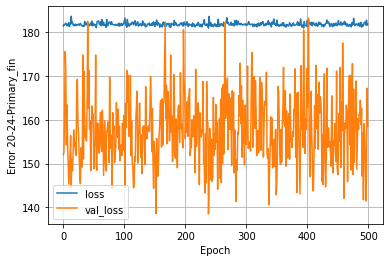

In [ ]:
plot_loss(history)

In [ ]:
weights         = linear_model.layers[1].kernel.numpy().flatten()
features        = list(input_df.columns)
feature_weights = list(zip(features, weights)) 

for f,w in sorted(feature_weights,key = lambda x: x[1]):
  print(f"{f:<40}:{w}")

20_yrs_old_child_mortality              :-12.861983299255371
20_yrs_old_children_per_woman           :-4.505788326263428
gdppercapita_us_infla_adjust            :-1.6364556550979614
10_yrs_old_gini_index                   :-1.6339577436447144
10_yrs_old_gdppercapita_us_infla_adjust :-1.511702060699463
10_yrs_old_co2_emissions_percapita      :0.9137111306190491
population                              :1.8830167055130005
gini_index                              :2.1103227138519287
life_expectancy                         :2.8753137588500977
co2_emissions_percapita                 :7.332895278930664


In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_input_df, test_output_df, verbose=0)


In [ ]:
test_input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_input_df, task=tfdf.keras.Task.REGRESSION)
test_output_np = test_output_df.to_numpy()
test_predicted = linear_model.predict(test_input_df)

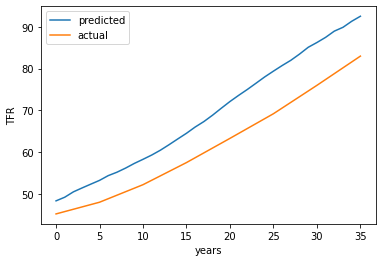

In [ ]:
plot_test_data(test_predicted,test_output_np)

In [ ]:
linear_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_28 (Dense)            (None, 1)                 11        
                                                                 
Total params: 32
Trainable params: 11
Non-trainable params: 21
_________________________________________________________________


### Regression using DNN

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_29 (Dense)            (None, 64)                704       
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    input_df,
    output_df,
    validation_split=0.2,
    verbose=0, epochs=10)

CPU times: user 2.01 s, sys: 102 ms, total: 2.12 s
Wall time: 1.86 s


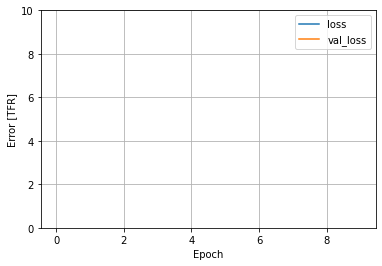

In [ ]:
plot_loss(history)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_input_df, test_output_df, verbose=0)

In [ ]:
test_output_np = test_output_df.to_numpy()
test_predicted = dnn_model.predict(test_input_df)

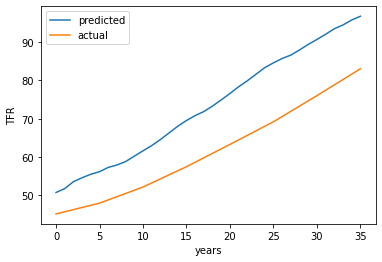

In [ ]:
plot_test_data(test_predicted,test_output_np)


In [ ]:
dnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_29 (Dense)            (None, 64)                704       
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


### Results

In [ ]:
test_results

{'dnn_model': 145.8124237060547,
 'gradient_tree': 375.4366760253906,
 'linear_model': 74.06234741210938,
 'predict': '20-24-Primary_fin',
 'random_forest': 200.87548828125}

# Finding of Top Performing Countries

In [ ]:
try:
  os.mkdir(root+"best_performers")
except:
  pass

### Life Expectany

In [ ]:
le_threshold_percentile = 85
le_start_percentile = 60    # it means consider bottom 60% of countries
le_parameter = 'life_expectancy'

In [ ]:
percentiles = [0.9,0.8,0.7,0.6,0.5,0.4]
le_pd = pd.read_csv(datasets_path[le_parameter])
describe = le_pd.describe(percentiles = percentiles)

le_pd.reset_index(inplace=True, drop=True)
le_pd.set_index(["Country"],inplace=True)
sk_start_value = le_pd.loc['South Korea']['1960']


In [ ]:
for i in percentiles:
  s_index = str(int(i*100))+"%"
  if describe.loc[s_index]['1960']>sk_start_value:
    start_value = describe.loc[s_index]['1960']
    break
start_value

70.4

In [ ]:
start_value = describe.loc[str(le_start_percentile)+"%"]["1960"]

In [ ]:
undeveloped_countries_pd = le_pd.loc[le_pd['1960'] < start_value ]
undeveloped_countries_pd

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,45.0,45.3,45.5,45.7,45.9,46.1,46.3,46.5,46.7,46.9,47.1,47.3,47.3,47.3,47.4,47.5,47.7,47.9,46.4,44.7,43.7,44.3,44.1,42.3,39.9,42.0,43.3,45.9,48.5,52.7,53.8,53.8,54.2,54.4,53.9,54.3,54.7,54.5,53.3,54.7,54.7,54.8,55.5,56.5,57.1,57.6,58.0,58.5,59.2,59.9,60.5,61.0,61.4,61.9,61.9,61.9
Angola,46.3,44.8,45.0,45.2,45.4,45.6,45.8,46.0,46.2,46.4,46.6,46.8,47.0,47.2,47.4,47.5,47.5,47.7,47.8,48.0,48.1,48.2,48.2,48.2,48.4,48.6,48.6,48.6,48.6,49.4,49.7,50.3,50.3,49.0,50.3,51.2,51.7,51.6,50.6,51.9,52.8,53.4,54.5,55.1,55.5,56.4,57.0,58.0,58.8,59.5,60.2,60.8,61.4,62.1,63.0,63.5
United Arab Emirates,60.3,60.8,61.3,61.6,62.1,62.6,63.0,63.4,63.8,64.2,64.0,64.9,65.1,65.4,65.7,66.0,66.3,66.6,67.0,67.3,67.6,68.0,68.1,67.9,68.4,68.5,68.5,68.5,68.5,68.6,68.7,68.7,68.8,68.8,68.7,68.8,68.9,69.0,69.2,69.2,69.1,69.2,69.4,69.3,69.1,69.2,69.5,70.0,70.4,70.6,70.8,71.0,71.2,71.6,73.0,73.2
Armenia,59.2,60.4,61.4,62.0,62.9,63.6,64.2,64.7,65.1,65.3,65.9,66.4,66.8,67.2,67.9,68.2,69.0,69.5,69.7,70.2,70.2,70.5,70.8,70.8,71.1,71.3,71.7,71.8,55.3,71.0,70.6,70.3,69.4,69.0,69.5,70.1,70.4,71.1,71.6,71.9,72.4,72.5,72.7,72.8,73.0,73.0,73.1,73.5,73.5,73.6,73.9,74.2,74.6,75.1,75.2,75.1
Azerbaijan,48.6,50.2,51.7,53.1,54.4,55.6,56.6,57.5,58.2,58.4,59.9,61.0,61.9,62.8,63.7,64.3,65.2,65.3,64.8,65.6,66.2,66.3,66.6,66.8,66.8,66.9,66.9,66.8,66.8,67.0,66.9,66.3,64.5,64.3,63.8,64.7,65.3,65.7,66.0,66.2,66.5,67.1,67.2,67.1,67.2,67.3,67.7,68.2,68.5,68.8,69.0,69.2,69.5,69.7,69.9,70.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Samoa,60.7,61.1,61.3,61.4,57.2,61.3,61.3,61.8,62.0,62.2,62.4,62.6,63.0,63.2,63.3,63.6,64.1,64.4,64.7,65.0,65.2,65.4,65.5,65.7,65.8,66.0,66.2,66.4,66.6,66.8,66.9,66.9,67.2,67.4,67.5,67.7,67.8,68.0,68.2,68.3,68.5,68.6,68.8,68.9,69.0,69.0,69.2,69.3,69.5,67.5,69.6,69.7,69.6,69.9,70.0,70.1
Yemen,36.5,37.1,36.3,36.9,37.6,38.2,38.8,39.4,40.2,41.0,41.9,44.3,45.4,46.6,47.6,48.7,49.8,50.9,51.8,52.6,53.3,54.0,54.3,55.5,56.1,56.7,55.2,57.7,58.2,58.6,59.1,59.5,59.9,60.3,60.5,61.1,61.5,62.0,62.5,63.0,63.5,64.0,64.5,64.9,65.3,65.8,66.2,66.5,66.9,67.2,67.6,67.8,67.9,68.4,68.5,68.2
South Africa,53.9,54.2,54.4,54.6,54.9,55.2,55.5,55.8,56.1,56.4,56.7,57.0,57.3,57.6,58.0,58.3,58.6,58.8,59.1,59.3,59.5,59.8,60.2,60.5,61.3,61.9,62.1,62.8,63.5,63.8,64.2,64.3,63.6,64.3,63.4,62.9,61.8,59.5,58.0,57.2,55.6,54.8,53.7,52.7,52.2,52.1,52.3,53.2,54.3,55.7,57.1,58.7,60.1,61.3,61.8,62.3


In [ ]:
le_threshold_value = undeveloped_countries_pd.describe(percentiles=[le_threshold_percentile/100]).loc[str(le_threshold_percentile)+"%"]["2015"]
le_fast_growing_nations = undeveloped_countries_pd.loc[undeveloped_countries_pd['2015'] > le_threshold_value]
le_fast_growing_nations = le_fast_growing_nations.append(le_pd.loc['Singapore'])
le_fast_growing_nations = le_fast_growing_nations.append(le_pd.loc['India'])
le_fast_growing_nations

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Armenia,59.2,60.4,61.4,62.0,62.9,63.6,64.2,64.7,65.1,65.3,65.9,66.4,66.8,67.2,67.9,68.2,69.0,69.5,69.7,70.2,70.2,70.5,70.8,70.8,71.1,71.3,71.7,71.8,55.3,71.0,70.6,70.3,69.4,69.0,69.5,70.1,70.4,71.1,71.6,71.9,72.4,72.5,72.7,72.8,73.0,73.0,73.1,73.5,73.5,73.6,73.9,74.2,74.6,75.1,75.2,75.1
Bahrain,57.3,58.1,58.8,59.5,60.2,60.9,61.5,62.1,62.9,63.5,64.2,64.9,65.4,66.0,66.4,66.8,67.2,67.5,66.9,68.2,68.4,68.7,69.0,69.2,69.2,69.4,69.0,69.4,69.4,69.5,69.5,69.5,69.8,70.1,70.3,70.5,70.7,70.9,71.0,71.2,71.7,73.4,72.7,72.2,72.3,72.7,73.0,73.6,74.0,74.5,75.0,75.3,75.7,76.2,76.6,76.8
Chile,54.2,57.5,56.8,57.1,57.6,58.7,59.2,60.2,61.0,61.5,62.0,62.6,62.3,63.2,64.9,66.2,66.2,67.2,68.2,68.6,69.4,70.5,71.0,70.9,71.3,72.0,72.6,73.2,73.2,73.2,73.4,74.2,74.7,75.0,75.2,75.3,75.5,76.0,76.2,76.5,76.9,77.0,77.4,77.4,77.6,77.9,78.2,78.4,78.7,78.6,78.6,79.0,79.2,79.3,79.5,79.6
China,27.8,40.8,53.5,57.4,57.9,58.5,59.0,59.5,59.9,60.4,60.9,61.4,61.9,62.4,62.5,62.8,62.6,63.5,63.8,64.0,64.4,64.7,65.3,65.7,66.1,66.6,67.1,67.3,67.5,67.7,68.1,68.4,68.7,69.0,69.4,69.8,70.1,70.5,70.9,71.2,71.3,71.7,72.0,72.3,72.5,73.0,73.7,74.2,74.3,74.7,74.9,75.3,75.7,76.1,76.4,76.8
Colombia,59.3,59.5,60.1,60.9,61.5,61.6,62.1,62.4,63.1,64.4,65.9,65.9,65.1,64.9,65.3,66.3,66.8,67.8,68.2,68.5,68.9,69.2,69.6,69.8,70.2,67.2,70.2,70.2,70.6,70.8,71.5,71.0,71.1,71.7,72.1,72.5,72.8,73.5,74.0,74.1,74.2,74.4,73.4,75.2,75.6,76.5,76.7,77.3,77.6,77.5,77.9,78.7,79.0,79.3,79.7,79.7
Algeria,52.4,51.5,51.5,55.8,56.7,56.8,56.2,56.1,56.1,56.1,56.2,56.2,56.3,56.5,56.7,56.9,57.1,57.8,58.2,58.8,58.7,59.9,60.8,62.3,63.3,64.7,65.5,66.0,66.6,67.1,67.5,67.9,68.3,68.6,68.7,69.0,69.6,69.7,70.2,70.7,71.0,71.3,71.8,72.0,72.6,72.9,73.3,73.6,73.9,74.2,74.5,74.7,74.9,75.1,75.3,75.4
Ecuador,56.1,57.2,57.7,58.2,59.3,59.8,60.0,60.4,60.9,60.8,61.4,62.0,62.2,62.5,63.2,64.1,64.8,65.7,66.0,66.7,67.0,67.9,68.4,68.3,69.1,69.9,70.4,69.1,70.8,71.5,72.0,71.5,72.1,72.5,73.2,73.6,73.5,74.2,74.1,74.2,74.5,75.0,74.1,73.9,73.9,73.6,73.6,73.7,73.8,74.1,74.3,74.9,74.9,75.2,75.6,75.9
Iran,44.5,45.3,45.4,47.0,47.8,48.7,49.6,50.4,51.0,53.1,54.5,56.0,57.1,58.9,60.2,61.5,62.6,63.5,62.6,64.6,64.7,64.8,64.4,65.2,66.2,66.3,65.2,66.5,66.8,68.1,66.7,68.9,69.3,69.6,70.0,70.4,70.7,70.9,71.3,71.6,71.9,72.2,72.5,71.8,73.2,73.5,74.0,74.4,74.8,75.1,75.5,75.8,76.0,76.2,76.5,76.7
Jordan,59.4,59.6,60.0,60.1,60.9,61.4,61.4,61.6,62.9,63.5,63.0,64.4,64.8,65.2,65.3,65.4,65.7,66.3,66.5,66.7,67.1,67.5,67.6,68.1,68.7,69.1,69.0,69.6,70.3,70.7,71.2,71.4,71.8,71.6,71.7,71.8,71.8,72.0,72.3,72.5,72.9,73.0,73.3,73.8,74.0,74.1,74.5,75.5,76.2,76.7,76.9,77.2,77.5,77.9,78.1,78.2


### Total Fertility

In [ ]:
tfr_threshold_percentile = 15
tfr_start_percentile = 60 # it means consider bottom 60% of countries
tfr_parameter = 'children_per_woman'
tfr_start_percentile = 100 - tfr_start_percentile

In [ ]:
percentiles = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2]
re_pd = pd.read_csv(datasets_path[tfr_parameter])
describe = re_pd.describe(percentiles = percentiles)

re_pd.reset_index(inplace=True, drop=True)
re_pd.set_index(["Country"],inplace=True)
sk_start_value = re_pd.loc['South Korea']['1960']

In [ ]:
for i in reversed(percentiles):
  s_index = str(int(i*100))+"%"
  if describe.loc[s_index]['1960']<sk_start_value:
    start_value = describe.loc[s_index]['1960']
print(start_value)

5.79


In [ ]:
start_value = describe.loc[str(tfr_start_percentile)+"%"]["1960"]
start_value

5.79

In [ ]:
undeveloped_countries_pd = re_pd.loc[re_pd['1960'] > start_value ]
undeveloped_countries_pd

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.46,7.46,7.46,7.46,7.46,7.46,7.47,7.48,7.50,7.54,7.57,7.61,7.63,7.64,7.62,7.57,7.49,7.39,7.27,7.14,6.99,6.83,6.65,6.46,6.25,6.04,5.82,5.60,5.38,5.17,4.98,4.80
Angola,7.48,7.52,7.56,7.59,7.61,7.62,7.62,7.61,7.61,7.60,7.60,7.60,7.61,7.61,7.61,7.62,7.61,7.59,7.57,7.54,7.50,7.47,7.44,7.41,7.39,7.38,7.37,7.35,7.32,7.29,7.25,7.19,7.13,7.06,6.99,6.92,6.85,6.79,6.73,6.68,6.64,6.60,6.57,6.54,6.50,6.47,6.42,6.37,6.31,6.24,6.16,6.08,6.00,5.92,5.84,5.77
Albania,6.49,6.40,6.28,6.13,5.96,5.77,5.58,5.39,5.22,5.06,4.91,4.78,4.64,4.51,4.37,4.24,4.10,3.97,3.84,3.73,3.62,3.53,3.45,3.38,3.32,3.27,3.22,3.16,3.11,3.05,2.98,2.91,2.83,2.75,2.67,2.59,2.51,2.42,2.33,2.25,2.16,2.07,1.98,1.90,1.82,1.75,1.70,1.67,1.65,1.65,1.65,1.67,1.69,1.70,1.71,1.71
United Arab Emirates,6.93,6.91,6.89,6.88,6.86,6.84,6.82,6.79,6.76,6.71,6.66,6.58,6.48,6.37,6.25,6.11,5.97,5.84,5.72,5.60,5.51,5.42,5.35,5.28,5.22,5.14,5.05,4.93,4.80,4.64,4.45,4.25,4.04,3.83,3.62,3.42,3.23,3.06,2.91,2.77,2.64,2.53,2.43,2.33,2.24,2.15,2.07,2.01,1.95,1.90,1.87,1.84,1.82,1.80,1.78,1.77
Azerbaijan,5.88,5.94,5.96,5.95,5.89,5.79,5.66,5.51,5.35,5.19,5.02,4.85,4.68,4.51,4.34,4.18,4.02,3.87,3.73,3.61,3.50,3.41,3.34,3.29,3.26,3.24,3.22,3.20,3.18,3.14,3.09,3.02,2.93,2.82,2.71,2.58,2.45,2.33,2.21,2.11,2.03,1.96,1.91,1.87,1.84,1.82,1.82,1.84,1.87,1.91,1.96,2.01,2.05,2.08,2.09,2.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Samoa,7.65,7.65,7.63,7.60,7.57,7.52,7.46,7.40,7.33,7.27,7.19,7.12,7.04,6.95,6.86,6.76,6.66,6.55,6.43,6.32,6.20,6.09,5.97,5.85,5.73,5.62,5.51,5.40,5.30,5.21,5.12,5.03,4.96,4.88,4.82,4.75,4.69,4.64,4.59,4.54,4.50,4.48,4.46,4.45,4.46,4.46,4.46,4.45,4.43,4.39,4.34,4.28,4.21,4.15,4.09,4.03
Yemen,7.49,7.53,7.58,7.62,7.67,7.71,7.74,7.76,7.78,7.79,7.81,7.85,7.92,8.00,8.12,8.24,8.38,8.50,8.61,8.69,8.75,8.80,8.83,8.85,8.86,8.87,8.86,8.83,8.79,8.71,8.61,8.46,8.27,8.05,7.80,7.53,7.25,6.99,6.74,6.51,6.31,6.13,5.95,5.78,5.60,5.43,5.25,5.09,4.94,4.80,4.67,4.55,4.44,4.33,4.22,4.10
South Africa,6.17,6.13,6.08,6.03,5.97,5.92,5.86,5.81,5.77,5.72,5.67,5.61,5.54,5.46,5.37,5.29,5.20,5.11,5.02,4.93,4.84,4.74,4.65,4.54,4.43,4.32,4.19,4.06,3.92,3.79,3.65,3.53,3.41,3.29,3.20,3.11,3.04,2.97,2.92,2.87,2.83,2.79,2.76,2.73,2.70,2.68,2.66,2.64,2.62,2.60,2.59,2.57,2.55,2.53,2.51,2.49


In [ ]:
tfr_threshold_value = undeveloped_countries_pd.describe(percentiles=[tfr_threshold_percentile/100]).loc[str(tfr_threshold_percentile)+"%"]["2015"]
tfr_fast_growing_nations = undeveloped_countries_pd.loc[undeveloped_countries_pd['2015'] < tfr_threshold_value]
tfr_fast_growing_nations = tfr_fast_growing_nations.append(re_pd.loc['China'])
tfr_fast_growing_nations = tfr_fast_growing_nations.append(re_pd.loc['India'])

### GDP per capita

In [ ]:
gdp_threshold_percentile = 85
gdp_start_percentile = 50 # it means consider bottom 50% of countries
start_year = '1990'
gdp_parameter = 'gdppercapita_us_infla_adjust'

In [ ]:
percentiles = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2]
re_pd = pd.read_csv(datasets_path[gdp_parameter])
describe = re_pd.describe(percentiles = percentiles)

re_pd.reset_index(inplace=True, drop=True)
re_pd.set_index(["Country"],inplace=True)
sk_start_value = re_pd.loc['South Korea'][start_year]

In [ ]:
re_pd.isna().sum()

1960    120
1961    117
1962    117
1963    117
1964    117
1965    113
1966    110
1967    109
1968    107
1969    107
1970     97
1971     97
1972     97
1973     97
1974     95
1975     93
1976     91
1977     85
1978     85
1979     84
1980     72
1981     68
1982     65
1983     65
1984     62
1985     61
1986     57
1987     54
1988     52
1989     51
1990     41
1991     40
1992     39
1993     38
1994     36
1995     25
1996     25
1997     22
1998     22
1999     21
2000     15
2001     14
2002      9
2003      9
2004      8
2005      8
2006      7
2007      7
2008      6
2009      5
2010      5
2011      4
2012      4
2013      2
2014      2
2015      0
dtype: int64

In [ ]:
for i in percentiles:
  s_index = str(int(i*100))+"%"
  if describe.loc[s_index][start_year]>sk_start_value:
    start_value = describe.loc[s_index][start_year]
print(start_value)

18200.0


In [ ]:
start_value = describe.loc[str(gdp_start_percentile)+"%"][start_year]
start_value

3200.0

In [ ]:
undeveloped_countries_pd = re_pd.loc[re_pd[start_year] < start_value ]
undeveloped_countries_pd

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3550.0,3280.0,3160.0,3180.0,3250.0,3250.0,3230.0,3240.0,3320.0,3210.0,3000.0,2930.0,2670.0,1960.0,1930.0,2150.0,2360.0,2450.0,2490.0,2460.0,2450.0,2470.0,2720.0,2710.0,2900.0,3220.0,3460.0,3810.0,4080.0,3960.0,3990.0,3980.0,4170.0,4220.0,4270.0,4170
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1740.0,1800.0,1820.0,1800.0,1740.0,1740.0,1800.0,1750.0,1690.0,1810.0,1610.0,1160.0,1090.0,1200.0,1310.0,1490.0,1630.0,1460.0,1600.0,1820.0,1960.0,2140.0,2250.0,2380.0,2520.0,2680.0,2850.0,3050.0,3300.0,3430.0,3580.0,3680.0,3740.0,3780.0,3860.0,3950
Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1650.0,1470.0,872.0,814.0,879.0,959.0,1030.0,1080.0,1160.0,1210.0,1290.0,1420.0,1620.0,1860.0,2060.0,2360.0,2700.0,3090.0,3340.0,2880.0,2960.0,3100.0,3310.0,3410.0,3510.0,3610
Azerbaijan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2870.0,2810.0,2140.0,1620.0,1280.0,1120.0,1120.0,1180.0,1280.0,1370.0,1500.0,1640.0,1780.0,1950.0,2110.0,2670.0,3560.0,4410.0,4780.0,5120.0,5300.0,5150.0,5190.0,5430.0,5510.0,5500
Burundi,285.0,241.0,258.0,264.0,275.0,279.0,285.0,316.0,308.0,296.0,353.0,357.0,331.0,350.0,343.0,341.0,361.0,394.0,380.0,377.0,371.0,406.0,391.0,395.0,385.0,418.0,420.0,431.0,440.0,434.0,439.0,450.0,445.0,409.0,387.0,351.0,319.0,311.0,322.0,315.0,307.0,306.0,311.0,298.0,303.0,296.0,302.0,302.0,307.0,308.0,313.0,316.0,319.0,325.0,328.0,306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vanuatu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2960.0,2550.0,2600.0,2590.0,2600.0,2790.0,2750.0,2690.0,2550.0,2450.0,2430.0,2640.0,2650.0,2640.0,2580.0,2740.0,2700.0,2710.0,2790.0,2770.0,2730.0,2840.0,2680.0,2480.0,2520.0,2550.0,2620.0,2780.0,2790.0,2880.0,2890.0,2860.0,2870.0,2820.0,2750.0,2760.0,2700
Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2600.0,2600.0,2620.0,2710.0,2850.0,2850.0,2810.0,2900.0,2760.0,2670.0,2640.0,2730.0,2630.0,2780.0,2970.0,2970.0,3020.0,3070.0,3270.0,3480.0,3610.0,3750.0,3900.0,4030.0,4090.0,4320.0,4330.0,4090.0,4080.0,4220.0,4010.0,3960.0,3930.0,4070
Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2040.0,2070.0,2120.0,2100.0,2140.0,2160.0,2180.0,2220.0,2290.0,2310.0,2380.0,2400.0,2430.0,2450.0,2470.0,2540.0,2540.0,2550.0,2570.0,2600.0,2720.0,2310.0,2300.0,2350.0,2280.0,1600


In [ ]:
gdp_threshold_value = undeveloped_countries_pd.describe(percentiles=[gdp_threshold_percentile/100]).loc[str(gdp_threshold_percentile)+"%"]["2015"]
gdp_fast_growing_nations = undeveloped_countries_pd.loc[undeveloped_countries_pd['2015'] > gdp_threshold_value]
gdp_fast_growing_nations = gdp_fast_growing_nations.append(re_pd.loc['South Korea'])
gdp_fast_growing_nations = gdp_fast_growing_nations.append(re_pd.loc['Singapore'])
gdp_fast_growing_nations = gdp_fast_growing_nations.append(re_pd.loc['India'])

### Primary Education OL

In [ ]:
edu_threshold_percentile = 15
edu_start_percentile = 70 # it means consider bottom 70% of countries
edu_parameter = '20-24-Primary_OL'
edu_start_percentile = 100 - edu_start_percentile

In [ ]:
percentiles = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2]
re_pd = pd.read_csv(datasets_path[edu_parameter])
describe = re_pd.describe(percentiles = percentiles)

re_pd.reset_index(inplace=True, drop=True)
re_pd.set_index(["Country"],inplace=True)
sk_start_value = re_pd.loc['South Korea']['1960']
print(sk_start_value)

61.6


In [ ]:
for i in reversed(percentiles):
  s_index = str(int(i*100))+"%"
  if describe.loc[s_index]['1960']<sk_start_value:
    start_value = describe.loc[s_index]['1960']
print(start_value)

48.019999999999996


In [ ]:
start_value = describe.loc[str(edu_start_percentile)+"%"]["1960"]
start_value

48.019999999999996

In [ ]:
undeveloped_countries_pd = re_pd.loc[re_pd['1960'] > start_value ]
undeveloped_countries_pd

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,99.9,99.90,99.90,99.90,99.90,99.9,99.84,99.78,99.72,99.66,99.6,99.50,99.40,99.30,99.20,99.1,98.96,98.82,98.68,98.54,98.4,98.26,98.12,97.98,97.84,97.7,97.58,97.46,97.34,97.22,97.1,96.94,96.78,96.62,96.46,96.3,96.02,95.74,95.46,95.18,94.9,94.32,93.74,93.16,92.58,92.0,90.94,89.88,88.82,87.76,86.7,85.68,84.66,83.64,82.62,81.6
Albania,49.7,46.78,43.86,40.94,38.02,35.1,31.96,28.82,25.68,22.54,19.4,17.36,15.32,13.28,11.24,9.2,8.36,7.52,6.68,5.84,5.0,4.76,4.52,4.28,4.04,3.8,3.80,3.80,3.80,3.80,3.8,3.90,4.00,4.10,4.20,4.3,4.52,4.74,4.96,5.18,5.4,5.52,5.64,5.76,5.88,6.0,6.12,6.24,6.36,6.48,6.6,6.18,5.76,5.34,4.92,4.5
Algeria,89.9,88.42,86.94,85.46,83.98,82.5,80.98,79.46,77.94,76.42,74.9,73.60,72.30,71.00,69.70,68.4,66.70,65.00,63.30,61.60,59.9,57.52,55.14,52.76,50.38,48.0,45.50,43.00,40.50,38.00,35.5,33.84,32.18,30.52,28.86,27.2,26.58,25.96,25.34,24.72,24.1,23.18,22.26,21.34,20.42,19.5,18.64,17.78,16.92,16.06,15.2,14.34,13.48,12.62,11.76,10.9
Angola,97.9,97.84,97.78,97.72,97.66,97.6,97.38,97.16,96.94,96.72,96.5,96.16,95.82,95.48,95.14,94.8,94.34,93.88,93.42,92.96,92.5,92.04,91.58,91.12,90.66,90.2,89.78,89.36,88.94,88.52,88.1,88.00,87.90,87.80,87.70,87.6,87.54,87.48,87.42,87.36,87.3,87.08,86.86,86.64,86.42,86.2,85.48,84.76,84.04,83.32,82.6,80.24,77.88,75.52,73.16,70.8
Argentina,73.5,72.58,71.66,70.74,69.82,68.9,67.88,66.86,65.84,64.82,63.8,62.74,61.68,60.62,59.56,58.5,57.48,56.46,55.44,54.42,53.4,52.60,51.80,51.00,50.20,49.4,48.48,47.56,46.64,45.72,44.8,44.06,43.32,42.58,41.84,41.1,40.54,39.98,39.42,38.86,38.3,37.14,35.98,34.82,33.66,32.5,31.88,31.26,30.64,30.02,29.4,28.50,27.60,26.70,25.80,24.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,82.8,81.08,79.36,77.64,75.92,74.2,72.22,70.24,68.26,66.28,64.3,62.78,61.26,59.74,58.22,56.7,55.54,54.38,53.22,52.06,50.9,50.30,49.70,49.10,48.50,47.9,48.00,48.10,48.20,48.30,48.4,48.62,48.84,49.06,49.28,49.5,49.92,50.34,50.76,51.18,51.6,50.34,49.08,47.82,46.56,45.3,43.28,41.26,39.24,37.22,35.2,33.30,31.40,29.50,27.60,25.7
World,64.1,63.32,62.54,61.76,60.98,60.2,59.06,57.92,56.78,55.64,54.5,53.56,52.62,51.68,50.74,49.8,48.78,47.76,46.74,45.72,44.7,43.88,43.06,42.24,41.42,40.6,40.18,39.76,39.34,38.92,38.5,38.04,37.58,37.12,36.66,36.2,35.88,35.56,35.24,34.92,34.6,33.96,33.32,32.68,32.04,31.4,30.66,29.92,29.18,28.44,27.7,27.30,26.90,26.50,26.10,25.7
Yemen,100.0,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.0,99.96,99.92,99.88,99.84,99.8,99.58,99.36,99.14,98.92,98.7,98.12,97.54,96.96,96.38,95.8,95.12,94.44,93.76,93.08,92.4,90.90,89.40,87.90,86.40,84.9,81.20,77.50,73.80,70.10,66.4


In [ ]:
edu_threshold_value = undeveloped_countries_pd.describe(percentiles=[edu_threshold_percentile/100]).loc[str(edu_threshold_percentile)+"%"]["2015"]
edu_fast_growing_nations = undeveloped_countries_pd.loc[undeveloped_countries_pd['2015'] < edu_threshold_value]
edu_fast_growing_nations = edu_fast_growing_nations.append(re_pd.loc['Thailand'])
edu_fast_growing_nations = edu_fast_growing_nations.append(re_pd.loc['India'])

## Adding Countries

In [ ]:
le_countries  = set(le_fast_growing_nations.index.values)
tfr_countries = set(tfr_fast_growing_nations.index.values)
gdp_countries = set(gdp_fast_growing_nations.index.values)
edu_countries = set(edu_fast_growing_nations.index.values)
all_countries = set()

print("le  & tfr  & gdp = " + str(le_countries.intersection(tfr_countries,gdp_countries )))
print("le  & tfr  & edu = " + str(le_countries.intersection(tfr_countries,edu_countries )))
print("gdp & tfr  & edu = " + str(gdp_countries.intersection(tfr_countries,edu_countries)))
print("gdp & le   & edu = " + str(gdp_countries.intersection(le_countries,edu_countries)))

print("\n")
print("le & tfr = "+str(le_countries.intersection(tfr_countries)))
print("le & gdp = "+str(le_countries.intersection(gdp_countries)))
print("le & edu = "+str(le_countries.intersection(edu_countries)))

print("tfr & gdp = "+str(tfr_countries.intersection(gdp_countries)))
print("tfr & edu = "+str(tfr_countries.intersection(edu_countries)))

print("gdp & edu = "+str(gdp_countries.intersection(edu_countries)))

all_countries = all_countries.union(le_countries, tfr_countries, gdp_countries, edu_countries)
all_countries
print(len(all_countries))

le  & tfr  & gdp = {'Singapore', 'China', 'South Korea', 'Thailand', 'India'}
le  & tfr  & edu = {'Singapore', 'China', 'South Korea', 'Thailand', 'India'}
gdp & tfr  & edu = {'Singapore', 'China', 'South Korea', 'Thailand', 'India'}
gdp & le   & edu = {'Singapore', 'China', 'South Korea', 'Thailand', 'India'}


le & tfr = {'Singapore', 'China', 'Bahrain', 'South Korea', 'Mauritius', 'Colombia', 'Thailand', 'Iran', 'St. Lucia', 'India'}
le & gdp = {'Singapore', 'China', 'Algeria', 'South Korea', 'Thailand', 'Peru', 'India'}
le & edu = {'Singapore', 'China', 'South Korea', 'Thailand', 'Chile', 'India'}
tfr & gdp = {'Singapore', 'China', 'South Korea', 'Thailand', 'India'}
tfr & edu = {'Singapore', 'China', 'Albania', 'South Korea', 'Thailand', 'Malaysia', 'India'}
gdp & edu = {'Singapore', 'China', 'South Korea', 'Thailand', 'India'}
54


# Plot country

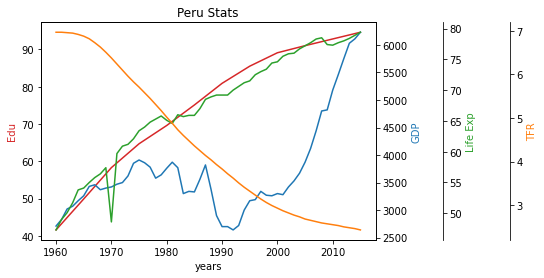

In [ ]:
import matplotlib.pyplot as plt

countries = ['Peru']

edu_parameter = "20-24-Primary_fin"
gdp_parameter = "gdppercapita_us_infla_adjust"
le_parameter  = "life_expectancy"
tfr_parameter = "children_per_woman"
# x axis values
years       = [y for y in range(1960,2016)]
x = years

for  country in countries:

  edu_df = pd.read_csv(datasets_path[edu_parameter])
  gdp_df = pd.read_csv(datasets_path[gdp_parameter])
  le_df  = pd.read_csv(datasets_path[le_parameter])
  tfr_df = pd.read_csv(datasets_path[tfr_parameter])

  fig, ax = plt.subplots()
  ax.set_xlabel('years')
  ax.set_ylabel("Edu", color="tab:red")
  # ax.ylim([0,100])
  twin1 = ax.twinx()
  color = 'tab:blue'
  twin1.set_ylabel('GDP', color=color)
  # twin1.set_ylim([0,30000])

  twin2 = ax.twinx()
  twin2.spines['right'].set_position(('axes', 1.2))
  color = 'tab:green'
  twin2.set_ylabel('Life Exp', color=color)
  # twin2.set_ylim([40,90])

  twin3 = ax.twinx()
  twin3.spines['right'].set_position(('axes', 1.4))
  color = 'tab:orange'
  twin3.set_ylabel('TFR', color=color)
  # twin3.set_ylim([0,7])


  edu_df = edu_df[edu_df.Country.isin([country])]
  gdp_df = gdp_df[gdp_df.Country.isin([country])]
  le_df  = le_df[le_df.Country.isin([country])]
  tfr_df = tfr_df[tfr_df.Country.isin([country])]
  
  y_edu = list(edu_df.values[0][1:])
  y_gdp = list(gdp_df.values[0][1:])
  y_le  = list(le_df.values[0][1:])
  y_tfr = list(tfr_df.values[0][1:])

  ax.plot(x,y_edu,label="Edu",color = "tab:red")
  twin1.plot(x, y_gdp,label="GDP", color='tab:blue')
  twin2.plot(x, y_le,label="Life Exp",color='tab:green')
  twin3.plot(x, y_tfr,label="TFR",color='tab:orange')
  
  # giving a title to my graph
  plt.title(country + ' Stats')
  
  # function to show the plot
  plt.show()

In [ ]:
import matplotlib.pyplot as plt

countries = ['Peru']

edu_parameter = "20-24-Primary_fin"
gdp_parameter = "gdppercapita_us_infla_adjust"
le_parameter  = "life_expectancy"
tfr_parameter = "children_per_woman"
# x axis values
years       = [y for y in range(1960,2016)]
x = years

for  country in countries:

  edu_df = pd.read_csv(datasets_path[edu_parameter])
  gdp_df = pd.read_csv(datasets_path[gdp_parameter])
  le_df  = pd.read_csv(datasets_path[le_parameter])
  tfr_df = pd.read_csv(datasets_path[tfr_parameter])
  # ax.ylim([0,100])
  
  y_edu = edu_df[edu_df.Country.isin([country])]
  y_gdp = gdp_df[gdp_df.Country.isin([country])]
  y_le  = le_df[le_df.Country.isin([country])]
  y_tfr = tfr_df[tfr_df.Country.isin([country])]

  y_edu = list(y_edu.values[0][1:])
  y_gdp = list(y_gdp.values[0][1:])
  y_le  = list(y_le.values[0][1:])
  y_tfr = list(y_tfr.values[0][1:])
  
  
  y_edu = [float(i)/sum(y_edu) for i in y_edu]
  y_gdp = [float(i)/sum(y_gdp) for i in y_gdp]
  y_le = [float(i)/sum(y_le) for i in y_le]
  y_tfr = [float(i)/sum(y_tfr) for i in y_tfr]
  
  plt.plot(x, y_edu,label="Education")
  plt.plot(x, y_gdp,label="GDP")
  plt.plot(x, y_le,label="Life Exp")
  plt.plot(x, y_tfr,label="TFR")

  ax.plot(x,y_edu,label="Edu",color = "tab:red")
  
  
  # giving a title to my graph
  plt.title(country + ' Stats')
  
  # function to show the plot
  plt.legend()
  plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.3, random_state=43)

# Save the summary

In [ ]:
#@markdown What changes you made to datasets & why ?


approach = 'for poor countries'  #@param {type: "string"}


In [ ]:
inspector = model.make_inspector()

In [ ]:
model_name = inspector.model_type()
num_trees  = inspector.num_trees()
objective  = inspector.objective()
eval = inspector.evaluation()

In [ ]:

input_features_list = inspector.features()
input_features = ""
for i in range(len(input_features_list)):
  input_features += str(i+1)+ "  "
  input_features += input_features_list[i][0] + "\n"

In [ ]:
variable_imp = []
variable_imp.append(extract_variable_imp(variable = 'MEAN_MIN_DEPTH'))
variable_imp.append(extract_variable_imp(variable = 'SUM_SCORE'))


In [ ]:
#@ Analysis
#@markdown Observations made from the output ?


anaylsis = ''  #@param {type: "string"}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open('/content/drive/My Drive/education-impact/final-doc.txt', 'a') as f:
  f.write("Model Trained : " + model_name+ "\n")
  f.write("Predicting : " + OUTPUT + "\n")
  f.write("Approach : " + approach + "\n")
  f.write("Num Examples: " + str(eval.num_examples) + "\n\n")
  f.write("Input Features\n")
  f.write(input_features+"\n\n")
  f.write("Model Performance\n")
  f.write("RMSE Score : "  + str(eval.rmse)+ "\n\n")
  for v in variable_imp:
    f.write(v + "\n\n")
  f.write("Analysis : " + anaylsis + "\n")
  f.write("\n\n\n")

  

# Models to try
 - RandomForestModel
 - GradientBoostedTreesModel
 - CartModel
 - DistributedGradientBoostedTreesModel

 - KNN Regression
 - Support Vector Regression
 - Locally Weighted Scatterplot Smoothing
 - Multivariate Adaptive Regression Splines
  

In [ ]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]